In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

# Set device for PyTorch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# LSTM Model for Stock Price Prediction
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Adjust for bidirectional LSTM
        self.dropout = nn.Dropout(0.2)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Function to download stock data
def download_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Function to create sliding windows for time series data
def create_sliding_windows(data, window_size, prediction_days=7):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_days + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + prediction_days].reshape(-1))
    return np.array(X), np.array(y)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

Using device: mps


In [13]:
def train(ticker):
  # Parameters
  # ticker = "RIVN"
  start_date = "2018-01-01"
  end_date = "2025-04-05"
  window_size = 30
  test_size = 0.2

  # Download data
  stock_data = download_stock_data(ticker, start_date, end_date)

  # Prepare features (using OHLCV data)
  features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].values

  # Normalize data
  scaler = MinMaxScaler(feature_range=(-1, 1))
  features_scaled = scaler.fit_transform(features)

  # Create sliding windows
  X, y = create_sliding_windows(features_scaled, window_size)

  # Split data into train and test sets
  split_idx = int(len(X) * (1 - test_size))
  X_train, X_test = X[:split_idx], X[split_idx:]
  y_train, y_test = y[:split_idx], y[split_idx:]

  # Convert to PyTorch tensors
  X_train_tensor = torch.FloatTensor(X_train).to(device)
  y_train_tensor = torch.FloatTensor(y_train).to(device)
  X_test_tensor = torch.FloatTensor(X_test).to(device)
  y_test_tensor = torch.FloatTensor(y_test).to(device)

  # Create DataLoader
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

  # Initialize model
  input_size = features.shape[1]  # Number of features
  hidden_size = 128
  num_layers = 2
  output_size = features.shape[1] * 7  # Predicting all features for 7 days

  model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)

  # Define loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Train the model
  losses = train_model(model, train_loader, criterion, optimizer, num_epochs=50)

  # Plot training loss
  plt.figure(figsize=(10, 6))
  plt.plot(losses)
  plt.title(f'Training Loss for {ticker} Stock Prediction')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
  return model, features_scaled, window_size, ticker, scaler, stock_data

In [14]:
def predict(
    model,
    features_scaled,
    window_size,
    ticker,
    scaler,
    stock_data
):
    # Make predictions for the next 7 days
    model.eval()
    with torch.no_grad():
        # Get the latest data for prediction
        latest_data = features_scaled[-window_size:]
        latest_data_tensor = torch.FloatTensor(latest_data).unsqueeze(0).to(device)
        
        # Make prediction
        prediction = model(latest_data_tensor).cpu().numpy()
        
        # Reshape prediction back to (7, 5) format
        prediction = prediction.reshape(7, 5)
        
        # Inverse transform predictions
        prediction_rescaled = scaler.inverse_transform(prediction)

    # Create dates for the next 7 days
    last_date = stock_data.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(7)]

    # Get the latest actual data from yfinance for comparison
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')
    latest_stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Plot the historical prices and predictions
    plt.figure(figsize=(14, 7))
    plt.plot(latest_stock_data.index, latest_stock_data['Close'], label='Historical Close')
    plt.plot(future_dates, prediction_rescaled[:, 3], 'r--', label='Predicted Close')
    plt.title(f'{ticker} Stock Price Prediction - Next 7 Days')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the predicted closing prices for the next 7 days
    print("\nPredicted closing prices for the next 7 days:")
    percentage_change = pr
    for date, price in zip(future_dates, prediction_rescaled[:, 3]):
        print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

[*********************100%***********************]  1 of 1 completed

Training model for RIVN


Epoch [1/50], Loss: 0.3287
Epoch [2/50], Loss: 0.1251
Epoch [3/50], Loss: 0.0939
Epoch [4/50], Loss: 0.0828
Epoch [5/50], Loss: 0.0709
Epoch [6/50], Loss: 0.0615
Epoch [7/50], Loss: 0.0518
Epoch [8/50], Loss: 0.0443
Epoch [9/50], Loss: 0.0366
Epoch [10/50], Loss: 0.0292
Epoch [11/50], Loss: 0.0257
Epoch [12/50], Loss: 0.0224
Epoch [13/50], Loss: 0.0216
Epoch [14/50], Loss: 0.0187
Epoch [15/50], Loss: 0.0180
Epoch [16/50], Loss: 0.0164
Epoch [17/50], Loss: 0.0154
Epoch [18/50], Loss: 0.0151
Epoch [19/50], Loss: 0.0140
Epoch [20/50], Loss: 0.0136
Epoch [21/50], Loss: 0.0145
Epoch [22/50], Loss: 0.0141
Epoch [23/50], Loss: 0.0131
Epoch [24/50], Loss: 0.0129
Epoch [25/50], Loss: 0.0137
Epoch [26/50], Loss: 0.0132
Epoch [27/50], Loss: 0.0123
Epoch [28/50], Loss: 0.0119
Epoch [29/50], Loss: 0.0120
Epoch [30/50], Loss: 0.0121
Epoch [31/50], Loss: 0.0121
Epoch [32/50], Loss: 0.0117
Epoch [33/50], Loss: 0.0116
Epoch [34/50], Loss: 0.0119
Epoch [35/50], Loss: 0.0116
Epoch [36/50], Loss: 0.0117
E

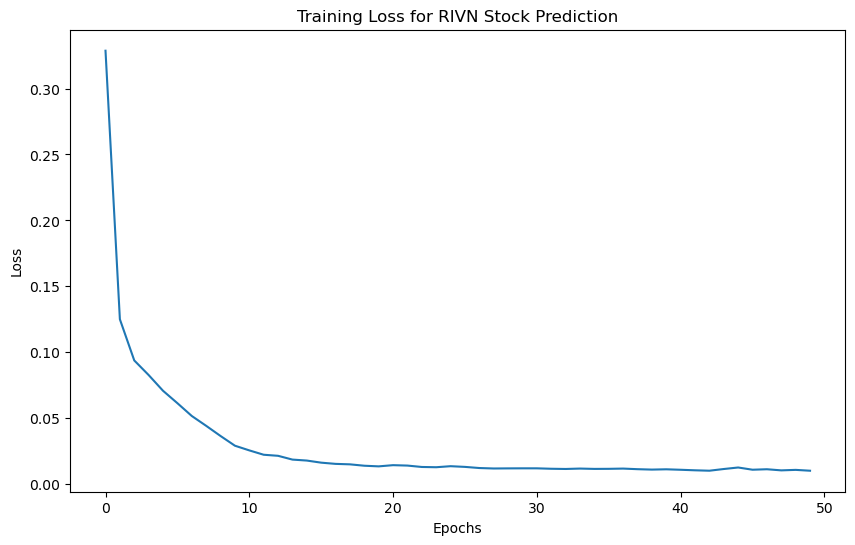

[*********************100%***********************]  1 of 1 completed

Predicting for RIVN


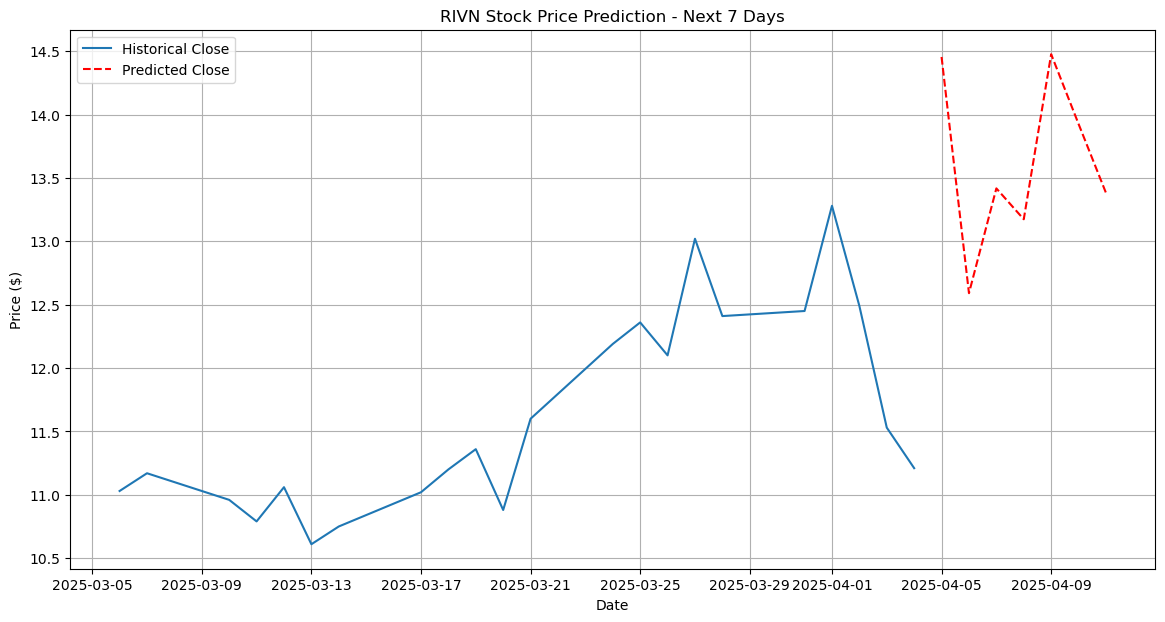


Predicted closing prices for the next 7 days:
2025-04-05: $14.45
2025-04-06: $12.59
2025-04-07: $13.42
2025-04-08: $13.17
2025-04-09: $14.48
2025-04-10: $13.93
2025-04-11: $13.38
Training model for NVDA


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1876
Epoch [2/50], Loss: 0.0869
Epoch [3/50], Loss: 0.0608
Epoch [4/50], Loss: 0.0393
Epoch [5/50], Loss: 0.0245
Epoch [6/50], Loss: 0.0174
Epoch [7/50], Loss: 0.0140
Epoch [8/50], Loss: 0.0128
Epoch [9/50], Loss: 0.0117
Epoch [10/50], Loss: 0.0108
Epoch [11/50], Loss: 0.0106
Epoch [12/50], Loss: 0.0101
Epoch [13/50], Loss: 0.0093
Epoch [14/50], Loss: 0.0091
Epoch [15/50], Loss: 0.0090
Epoch [16/50], Loss: 0.0089
Epoch [17/50], Loss: 0.0084
Epoch [18/50], Loss: 0.0083
Epoch [19/50], Loss: 0.0085
Epoch [20/50], Loss: 0.0085
Epoch [21/50], Loss: 0.0085
Epoch [22/50], Loss: 0.0082
Epoch [23/50], Loss: 0.0078
Epoch [24/50], Loss: 0.0081
Epoch [25/50], Loss: 0.0079
Epoch [26/50], Loss: 0.0077
Epoch [27/50], Loss: 0.0075
Epoch [28/50], Loss: 0.0075
Epoch [29/50], Loss: 0.0075
Epoch [30/50], Loss: 0.0075
Epoch [31/50], Loss: 0.0076
Epoch [32/50], Loss: 0.0076
Epoch [33/50], Loss: 0.0074
Epoch [34/50], Loss: 0.0072
Epoch [35/50], Loss: 0.0074
Epoch [36/50], Loss: 0.0070
E

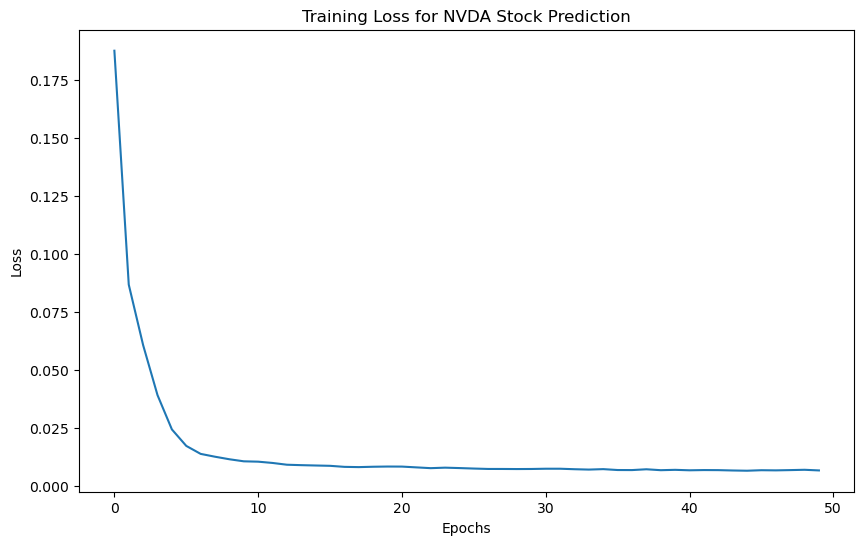

[*********************100%***********************]  1 of 1 completed

Predicting for NVDA


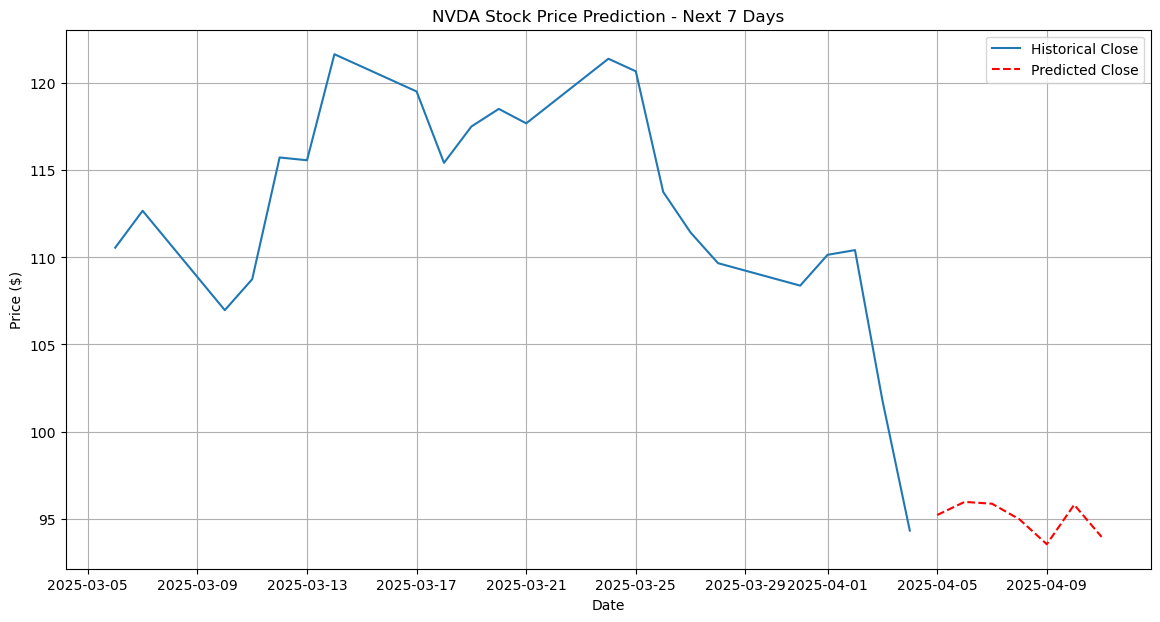


Predicted closing prices for the next 7 days:
2025-04-05: $95.21
2025-04-06: $95.96
2025-04-07: $95.85
2025-04-08: $94.96
2025-04-09: $93.53
2025-04-10: $95.80
2025-04-11: $93.95
Training model for NIO


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1883
Epoch [2/50], Loss: 0.0857
Epoch [3/50], Loss: 0.0670
Epoch [4/50], Loss: 0.0485
Epoch [5/50], Loss: 0.0350
Epoch [6/50], Loss: 0.0256
Epoch [7/50], Loss: 0.0199
Epoch [8/50], Loss: 0.0171
Epoch [9/50], Loss: 0.0154
Epoch [10/50], Loss: 0.0146
Epoch [11/50], Loss: 0.0140
Epoch [12/50], Loss: 0.0140
Epoch [13/50], Loss: 0.0135
Epoch [14/50], Loss: 0.0129
Epoch [15/50], Loss: 0.0126
Epoch [16/50], Loss: 0.0125
Epoch [17/50], Loss: 0.0122
Epoch [18/50], Loss: 0.0122
Epoch [19/50], Loss: 0.0125
Epoch [20/50], Loss: 0.0129
Epoch [21/50], Loss: 0.0122
Epoch [22/50], Loss: 0.0126
Epoch [23/50], Loss: 0.0119
Epoch [24/50], Loss: 0.0115
Epoch [25/50], Loss: 0.0114
Epoch [26/50], Loss: 0.0110
Epoch [27/50], Loss: 0.0111
Epoch [28/50], Loss: 0.0109
Epoch [29/50], Loss: 0.0112
Epoch [30/50], Loss: 0.0111
Epoch [31/50], Loss: 0.0114
Epoch [32/50], Loss: 0.0114
Epoch [33/50], Loss: 0.0110
Epoch [34/50], Loss: 0.0111
Epoch [35/50], Loss: 0.0104
Epoch [36/50], Loss: 0.0103
E

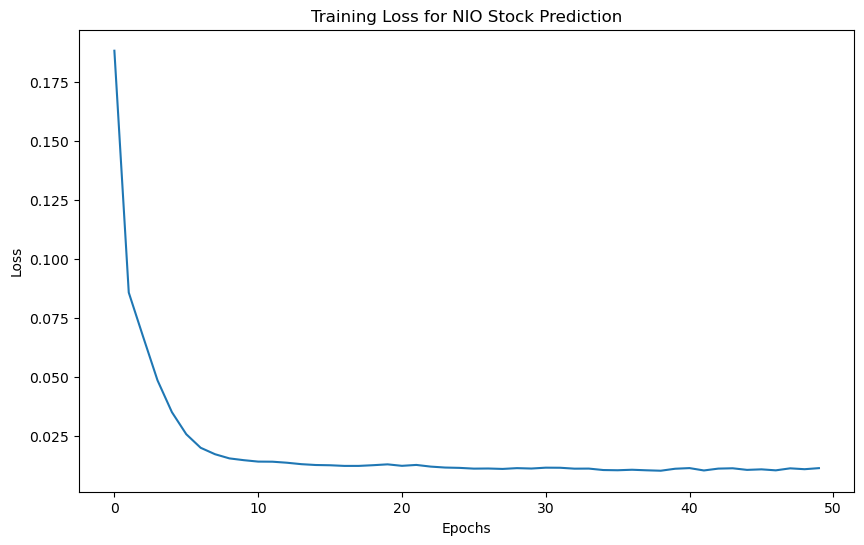

[*********************100%***********************]  1 of 1 completed

Predicting for NIO


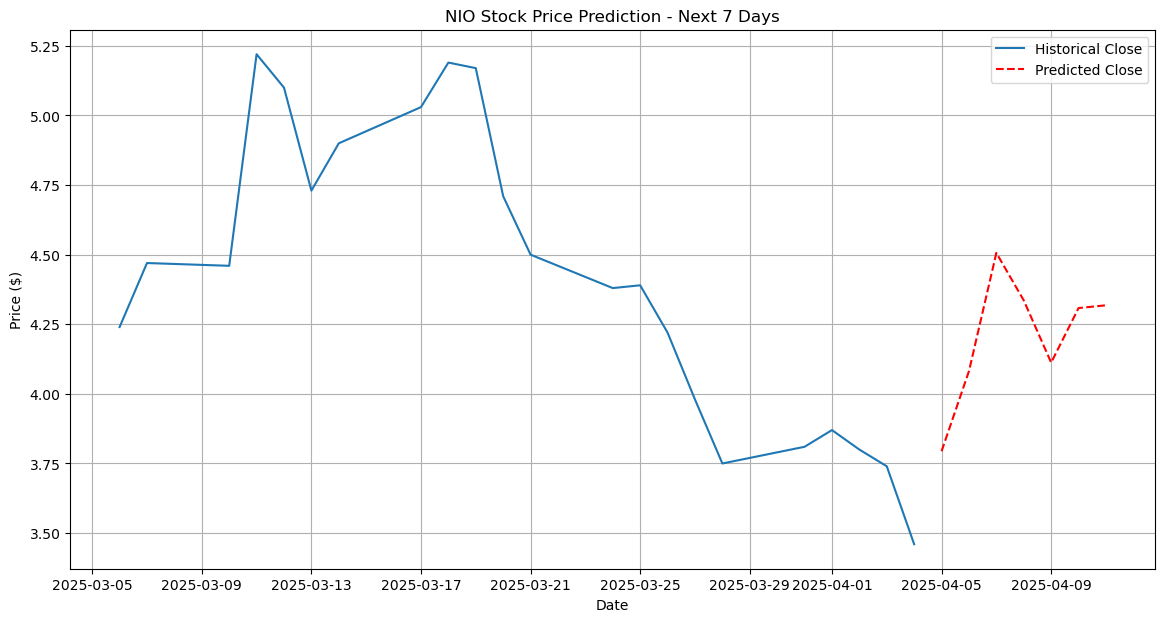


Predicted closing prices for the next 7 days:
2025-04-05: $3.79
2025-04-06: $4.08
2025-04-07: $4.51
2025-04-08: $4.34
2025-04-09: $4.11
2025-04-10: $4.31
2025-04-11: $4.32
Training model for TSM


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1942
Epoch [2/50], Loss: 0.0739
Epoch [3/50], Loss: 0.0514
Epoch [4/50], Loss: 0.0348
Epoch [5/50], Loss: 0.0247
Epoch [6/50], Loss: 0.0180
Epoch [7/50], Loss: 0.0141
Epoch [8/50], Loss: 0.0118
Epoch [9/50], Loss: 0.0105
Epoch [10/50], Loss: 0.0094
Epoch [11/50], Loss: 0.0090
Epoch [12/50], Loss: 0.0085
Epoch [13/50], Loss: 0.0084
Epoch [14/50], Loss: 0.0080
Epoch [15/50], Loss: 0.0079
Epoch [16/50], Loss: 0.0076
Epoch [17/50], Loss: 0.0075
Epoch [18/50], Loss: 0.0074
Epoch [19/50], Loss: 0.0072
Epoch [20/50], Loss: 0.0070
Epoch [21/50], Loss: 0.0070
Epoch [22/50], Loss: 0.0069
Epoch [23/50], Loss: 0.0071
Epoch [24/50], Loss: 0.0070
Epoch [25/50], Loss: 0.0066
Epoch [26/50], Loss: 0.0067
Epoch [27/50], Loss: 0.0068
Epoch [28/50], Loss: 0.0068
Epoch [29/50], Loss: 0.0067
Epoch [30/50], Loss: 0.0066
Epoch [31/50], Loss: 0.0066
Epoch [32/50], Loss: 0.0066
Epoch [33/50], Loss: 0.0064
Epoch [34/50], Loss: 0.0065
Epoch [35/50], Loss: 0.0066
Epoch [36/50], Loss: 0.0063
E

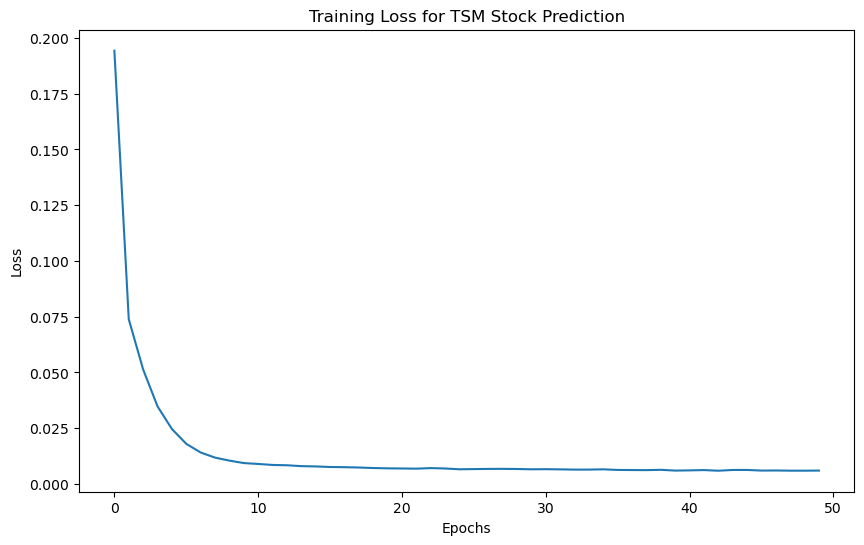

[*********************100%***********************]  1 of 1 completed

Predicting for TSM


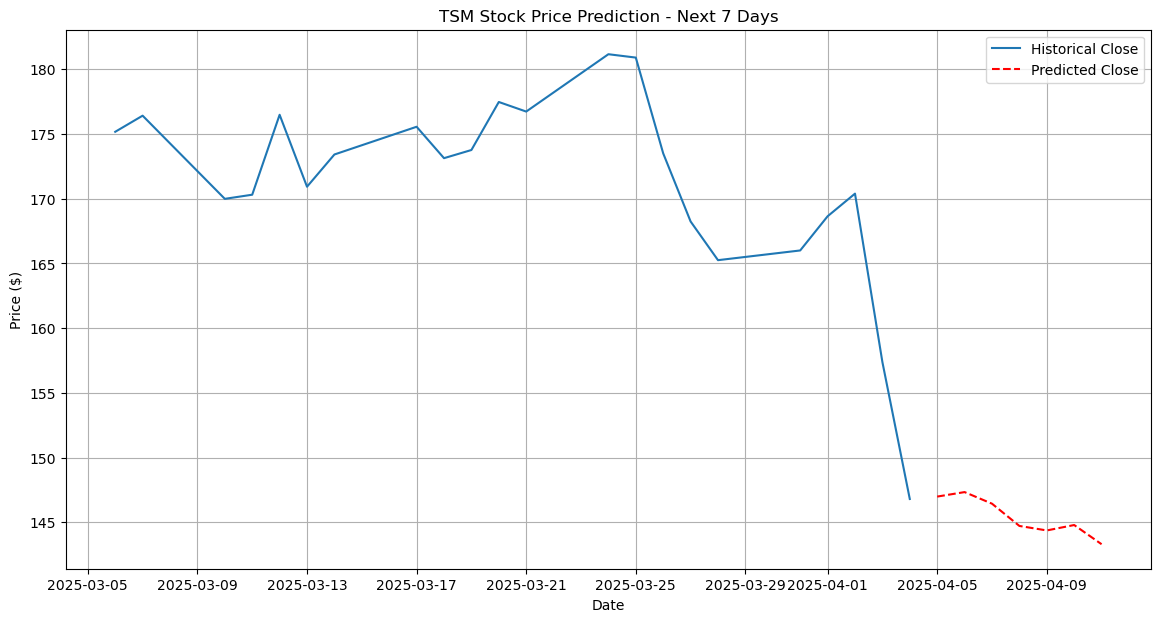


Predicted closing prices for the next 7 days:
2025-04-05: $146.99
2025-04-06: $147.33
2025-04-07: $146.44
2025-04-08: $144.72
2025-04-09: $144.37
2025-04-10: $144.79
2025-04-11: $143.31
Training model for WMT


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1779
Epoch [2/50], Loss: 0.0791
Epoch [3/50], Loss: 0.0521
Epoch [4/50], Loss: 0.0330
Epoch [5/50], Loss: 0.0207
Epoch [6/50], Loss: 0.0151
Epoch [7/50], Loss: 0.0129
Epoch [8/50], Loss: 0.0114
Epoch [9/50], Loss: 0.0111
Epoch [10/50], Loss: 0.0105
Epoch [11/50], Loss: 0.0102
Epoch [12/50], Loss: 0.0101
Epoch [13/50], Loss: 0.0096
Epoch [14/50], Loss: 0.0093
Epoch [15/50], Loss: 0.0091
Epoch [16/50], Loss: 0.0089
Epoch [17/50], Loss: 0.0088
Epoch [18/50], Loss: 0.0086
Epoch [19/50], Loss: 0.0090
Epoch [20/50], Loss: 0.0087
Epoch [21/50], Loss: 0.0086
Epoch [22/50], Loss: 0.0083
Epoch [23/50], Loss: 0.0085
Epoch [24/50], Loss: 0.0083
Epoch [25/50], Loss: 0.0083
Epoch [26/50], Loss: 0.0083
Epoch [27/50], Loss: 0.0082
Epoch [28/50], Loss: 0.0080
Epoch [29/50], Loss: 0.0078
Epoch [30/50], Loss: 0.0082
Epoch [31/50], Loss: 0.0078
Epoch [32/50], Loss: 0.0081
Epoch [33/50], Loss: 0.0081
Epoch [34/50], Loss: 0.0078
Epoch [35/50], Loss: 0.0077
Epoch [36/50], Loss: 0.0077
E

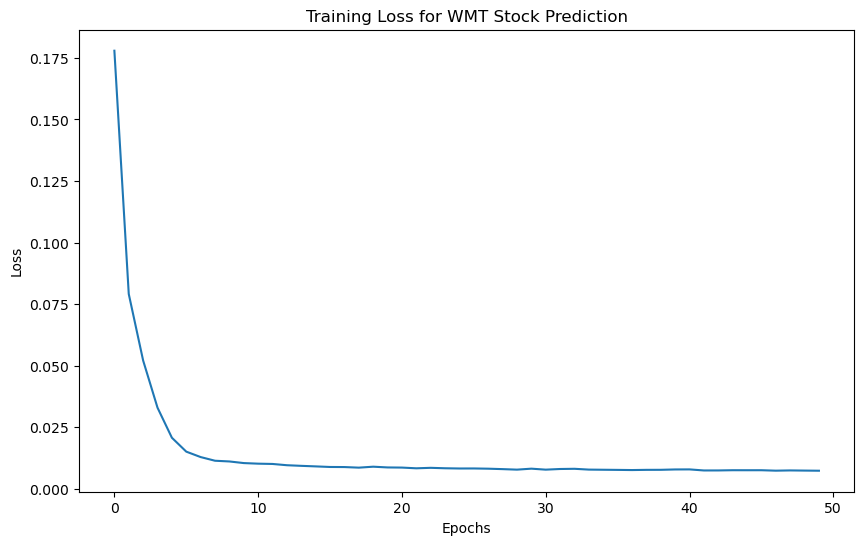

Predicting for WMT


[*********************100%***********************]  1 of 1 completed


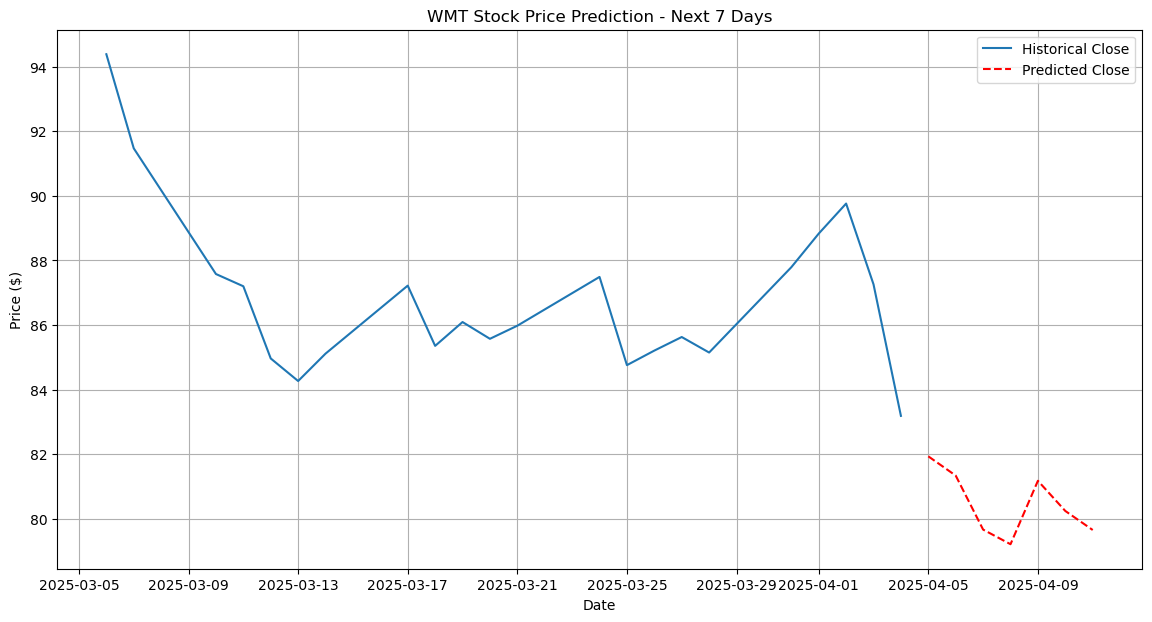


Predicted closing prices for the next 7 days:
2025-04-05: $81.94
2025-04-06: $81.34
2025-04-07: $79.67
2025-04-08: $79.22
2025-04-09: $81.18
2025-04-10: $80.25
2025-04-11: $79.66
Training model for JNJ


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1664
Epoch [2/50], Loss: 0.0766
Epoch [3/50], Loss: 0.0537
Epoch [4/50], Loss: 0.0334
Epoch [5/50], Loss: 0.0217
Epoch [6/50], Loss: 0.0163
Epoch [7/50], Loss: 0.0141
Epoch [8/50], Loss: 0.0129
Epoch [9/50], Loss: 0.0122
Epoch [10/50], Loss: 0.0121
Epoch [11/50], Loss: 0.0114
Epoch [12/50], Loss: 0.0113
Epoch [13/50], Loss: 0.0109
Epoch [14/50], Loss: 0.0104
Epoch [15/50], Loss: 0.0102
Epoch [16/50], Loss: 0.0102
Epoch [17/50], Loss: 0.0106
Epoch [18/50], Loss: 0.0099
Epoch [19/50], Loss: 0.0100
Epoch [20/50], Loss: 0.0095
Epoch [21/50], Loss: 0.0096
Epoch [22/50], Loss: 0.0094
Epoch [23/50], Loss: 0.0093
Epoch [24/50], Loss: 0.0096
Epoch [25/50], Loss: 0.0095
Epoch [26/50], Loss: 0.0093
Epoch [27/50], Loss: 0.0091
Epoch [28/50], Loss: 0.0089
Epoch [29/50], Loss: 0.0090
Epoch [30/50], Loss: 0.0089
Epoch [31/50], Loss: 0.0092
Epoch [32/50], Loss: 0.0091
Epoch [33/50], Loss: 0.0087
Epoch [34/50], Loss: 0.0087
Epoch [35/50], Loss: 0.0087
Epoch [36/50], Loss: 0.0087
E

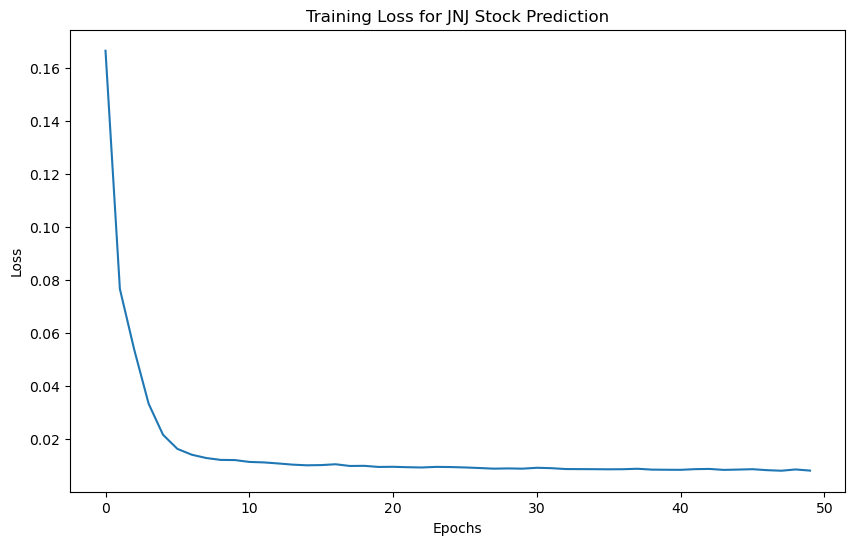

Predicting for JNJ


[*********************100%***********************]  1 of 1 completed


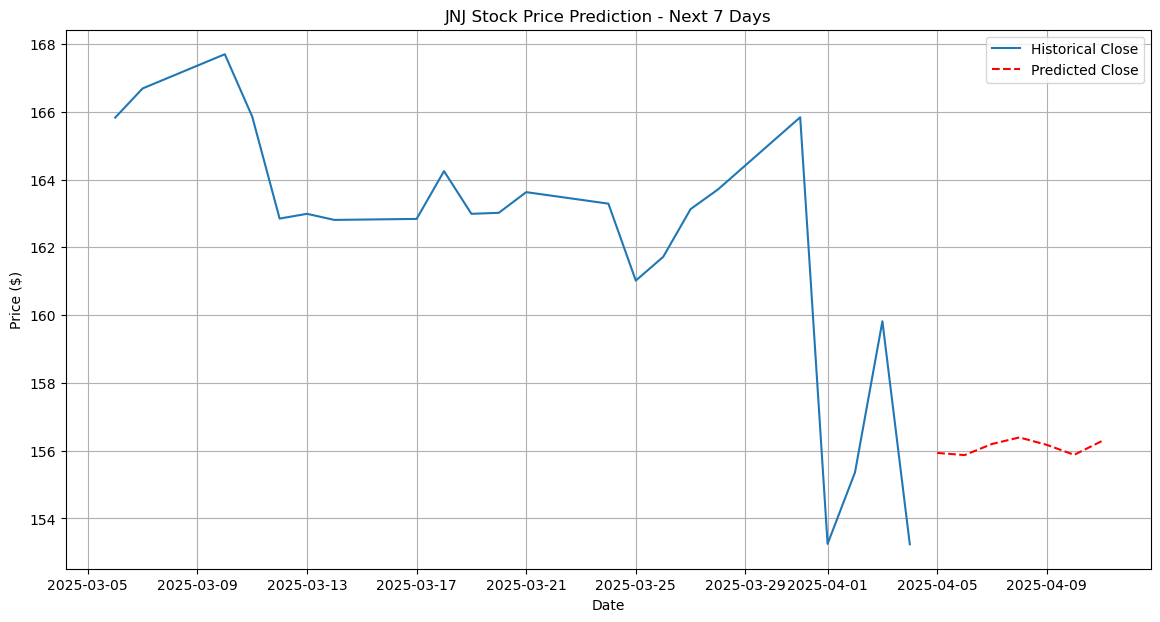


Predicted closing prices for the next 7 days:
2025-04-05: $155.93
2025-04-06: $155.87
2025-04-07: $156.20
2025-04-08: $156.39
2025-04-09: $156.17
2025-04-10: $155.88
2025-04-11: $156.28
Training model for VZ


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1681
Epoch [2/50], Loss: 0.0780
Epoch [3/50], Loss: 0.0540
Epoch [4/50], Loss: 0.0365
Epoch [5/50], Loss: 0.0258
Epoch [6/50], Loss: 0.0213
Epoch [7/50], Loss: 0.0188
Epoch [8/50], Loss: 0.0176
Epoch [9/50], Loss: 0.0168
Epoch [10/50], Loss: 0.0162
Epoch [11/50], Loss: 0.0158
Epoch [12/50], Loss: 0.0156
Epoch [13/50], Loss: 0.0149
Epoch [14/50], Loss: 0.0150
Epoch [15/50], Loss: 0.0148
Epoch [16/50], Loss: 0.0144
Epoch [17/50], Loss: 0.0149
Epoch [18/50], Loss: 0.0143
Epoch [19/50], Loss: 0.0144
Epoch [20/50], Loss: 0.0144
Epoch [21/50], Loss: 0.0150
Epoch [22/50], Loss: 0.0141
Epoch [23/50], Loss: 0.0141
Epoch [24/50], Loss: 0.0137
Epoch [25/50], Loss: 0.0141
Epoch [26/50], Loss: 0.0141
Epoch [27/50], Loss: 0.0133
Epoch [28/50], Loss: 0.0135
Epoch [29/50], Loss: 0.0133
Epoch [30/50], Loss: 0.0140
Epoch [31/50], Loss: 0.0131
Epoch [32/50], Loss: 0.0135
Epoch [33/50], Loss: 0.0129
Epoch [34/50], Loss: 0.0132
Epoch [35/50], Loss: 0.0131
Epoch [36/50], Loss: 0.0132
E

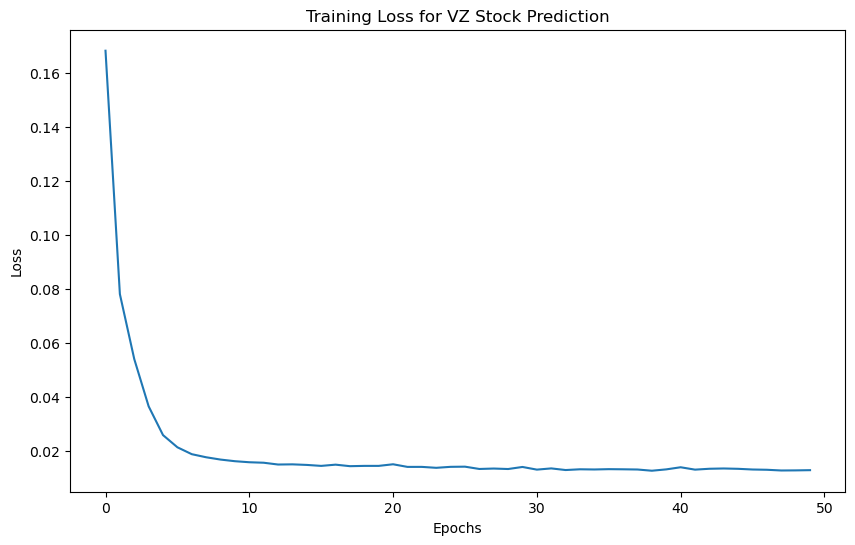

Predicting for VZ


[*********************100%***********************]  1 of 1 completed


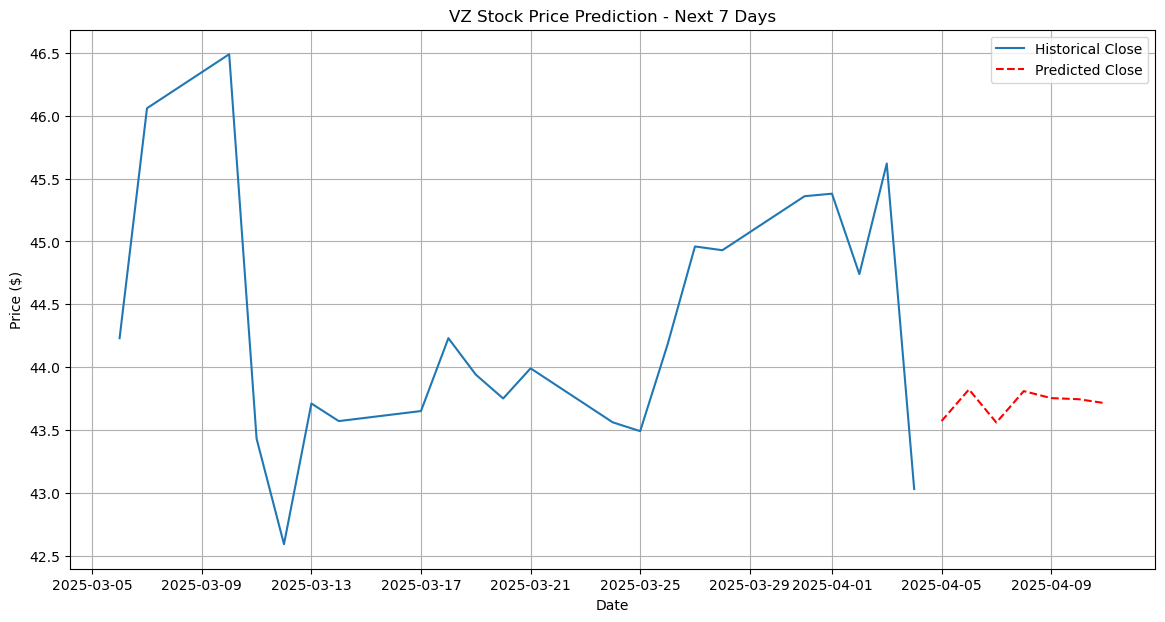


Predicted closing prices for the next 7 days:
2025-04-05: $43.57
2025-04-06: $43.82
2025-04-07: $43.56
2025-04-08: $43.81
2025-04-09: $43.75
2025-04-10: $43.74
2025-04-11: $43.71
Training model for PFE


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1605
Epoch [2/50], Loss: 0.0737
Epoch [3/50], Loss: 0.0540
Epoch [4/50], Loss: 0.0350
Epoch [5/50], Loss: 0.0217
Epoch [6/50], Loss: 0.0143
Epoch [7/50], Loss: 0.0117
Epoch [8/50], Loss: 0.0104
Epoch [9/50], Loss: 0.0099
Epoch [10/50], Loss: 0.0092
Epoch [11/50], Loss: 0.0091
Epoch [12/50], Loss: 0.0086
Epoch [13/50], Loss: 0.0084
Epoch [14/50], Loss: 0.0086
Epoch [15/50], Loss: 0.0086
Epoch [16/50], Loss: 0.0082
Epoch [17/50], Loss: 0.0079
Epoch [18/50], Loss: 0.0079
Epoch [19/50], Loss: 0.0077
Epoch [20/50], Loss: 0.0077
Epoch [21/50], Loss: 0.0076
Epoch [22/50], Loss: 0.0076
Epoch [23/50], Loss: 0.0079
Epoch [24/50], Loss: 0.0074
Epoch [25/50], Loss: 0.0074
Epoch [26/50], Loss: 0.0073
Epoch [27/50], Loss: 0.0072
Epoch [28/50], Loss: 0.0071
Epoch [29/50], Loss: 0.0069
Epoch [30/50], Loss: 0.0073
Epoch [31/50], Loss: 0.0068
Epoch [32/50], Loss: 0.0068
Epoch [33/50], Loss: 0.0069
Epoch [34/50], Loss: 0.0070
Epoch [35/50], Loss: 0.0070
Epoch [36/50], Loss: 0.0067
E

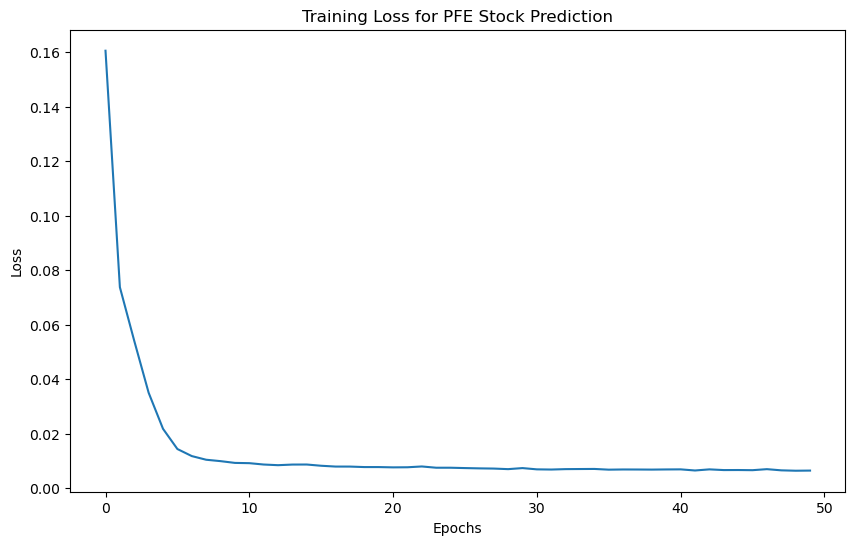

Predicting for PFE


[*********************100%***********************]  1 of 1 completed


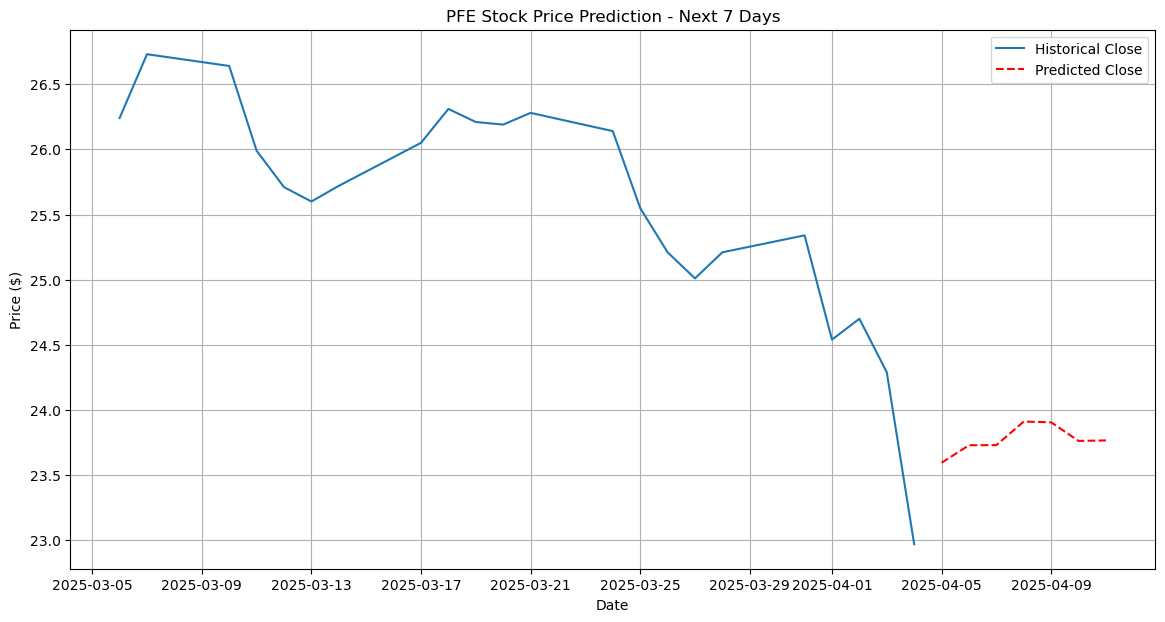


Predicted closing prices for the next 7 days:
2025-04-05: $23.60
2025-04-06: $23.73
2025-04-07: $23.73
2025-04-08: $23.91
2025-04-09: $23.91
2025-04-10: $23.76
2025-04-11: $23.77
Training model for BA


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1667
Epoch [2/50], Loss: 0.0726
Epoch [3/50], Loss: 0.0477
Epoch [4/50], Loss: 0.0302
Epoch [5/50], Loss: 0.0209
Epoch [6/50], Loss: 0.0168
Epoch [7/50], Loss: 0.0147
Epoch [8/50], Loss: 0.0137
Epoch [9/50], Loss: 0.0130
Epoch [10/50], Loss: 0.0126
Epoch [11/50], Loss: 0.0126
Epoch [12/50], Loss: 0.0125
Epoch [13/50], Loss: 0.0116
Epoch [14/50], Loss: 0.0126
Epoch [15/50], Loss: 0.0114
Epoch [16/50], Loss: 0.0113
Epoch [17/50], Loss: 0.0114
Epoch [18/50], Loss: 0.0109
Epoch [19/50], Loss: 0.0107
Epoch [20/50], Loss: 0.0112
Epoch [21/50], Loss: 0.0108
Epoch [22/50], Loss: 0.0109
Epoch [23/50], Loss: 0.0106
Epoch [24/50], Loss: 0.0107
Epoch [25/50], Loss: 0.0107
Epoch [26/50], Loss: 0.0105
Epoch [27/50], Loss: 0.0105
Epoch [28/50], Loss: 0.0102
Epoch [29/50], Loss: 0.0097
Epoch [30/50], Loss: 0.0099
Epoch [31/50], Loss: 0.0097
Epoch [32/50], Loss: 0.0101
Epoch [33/50], Loss: 0.0105
Epoch [34/50], Loss: 0.0102
Epoch [35/50], Loss: 0.0112
Epoch [36/50], Loss: 0.0098
E

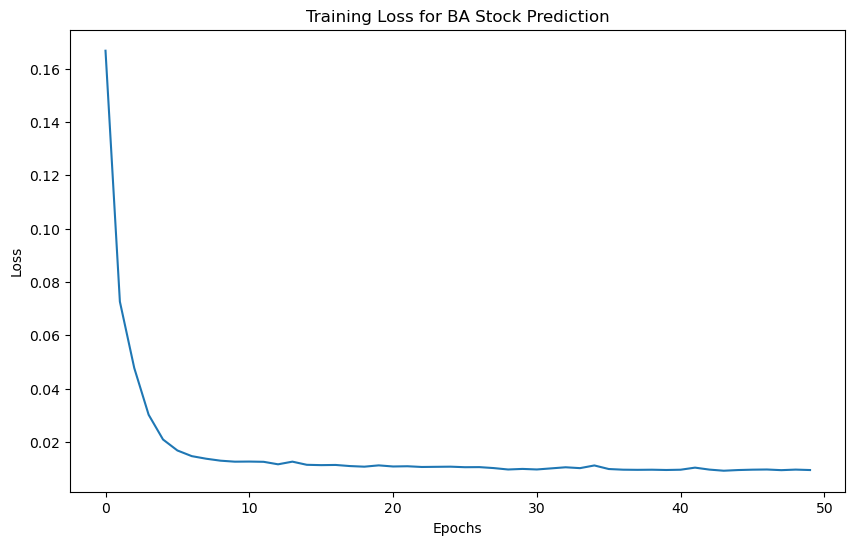

Predicting for BA


[*********************100%***********************]  1 of 1 completed


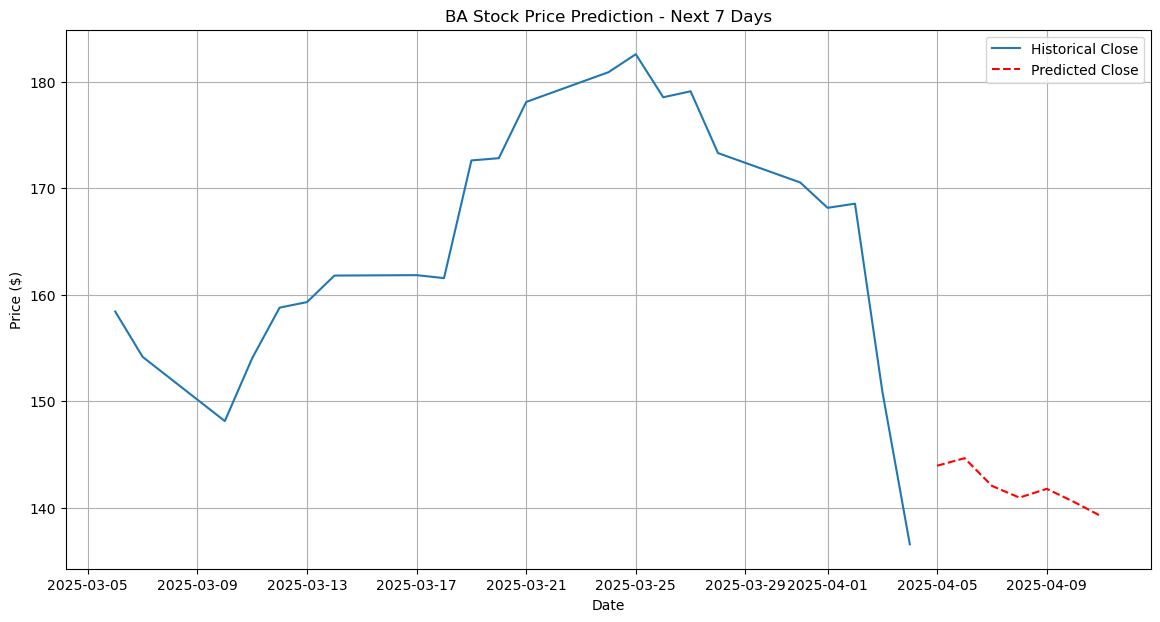


Predicted closing prices for the next 7 days:
2025-04-05: $143.96
2025-04-06: $144.67
2025-04-07: $142.06
2025-04-08: $140.97
2025-04-09: $141.79
2025-04-10: $140.55
2025-04-11: $139.20
Training model for CAT


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1731
Epoch [2/50], Loss: 0.0685
Epoch [3/50], Loss: 0.0476
Epoch [4/50], Loss: 0.0304
Epoch [5/50], Loss: 0.0207
Epoch [6/50], Loss: 0.0155
Epoch [7/50], Loss: 0.0127
Epoch [8/50], Loss: 0.0116
Epoch [9/50], Loss: 0.0105
Epoch [10/50], Loss: 0.0101
Epoch [11/50], Loss: 0.0094
Epoch [12/50], Loss: 0.0092
Epoch [13/50], Loss: 0.0091
Epoch [14/50], Loss: 0.0088
Epoch [15/50], Loss: 0.0088
Epoch [16/50], Loss: 0.0084
Epoch [17/50], Loss: 0.0081
Epoch [18/50], Loss: 0.0081
Epoch [19/50], Loss: 0.0084
Epoch [20/50], Loss: 0.0081
Epoch [21/50], Loss: 0.0080
Epoch [22/50], Loss: 0.0078
Epoch [23/50], Loss: 0.0079
Epoch [24/50], Loss: 0.0079
Epoch [25/50], Loss: 0.0078
Epoch [26/50], Loss: 0.0080
Epoch [27/50], Loss: 0.0076
Epoch [28/50], Loss: 0.0075
Epoch [29/50], Loss: 0.0073
Epoch [30/50], Loss: 0.0075
Epoch [31/50], Loss: 0.0074
Epoch [32/50], Loss: 0.0073
Epoch [33/50], Loss: 0.0072
Epoch [34/50], Loss: 0.0072
Epoch [35/50], Loss: 0.0076
Epoch [36/50], Loss: 0.0073
E

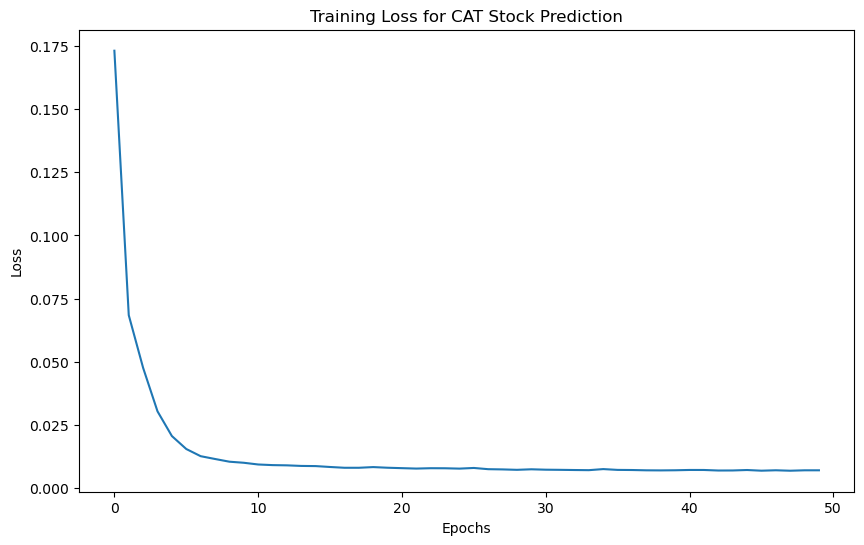

Predicting for CAT


[*********************100%***********************]  1 of 1 completed


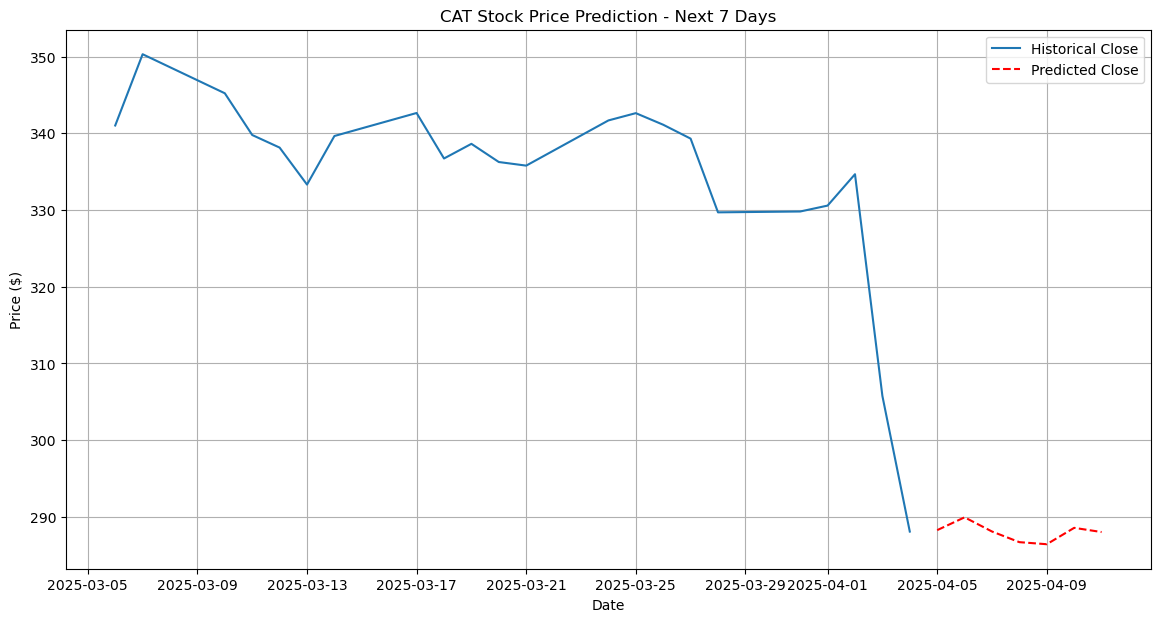


Predicted closing prices for the next 7 days:
2025-04-05: $288.27
2025-04-06: $289.94
2025-04-07: $288.09
2025-04-08: $286.70
2025-04-09: $286.43
2025-04-10: $288.57
2025-04-11: $288.02
Training model for MMM


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1461
Epoch [2/50], Loss: 0.0719
Epoch [3/50], Loss: 0.0473
Epoch [4/50], Loss: 0.0293
Epoch [5/50], Loss: 0.0189
Epoch [6/50], Loss: 0.0148
Epoch [7/50], Loss: 0.0128
Epoch [8/50], Loss: 0.0117
Epoch [9/50], Loss: 0.0108
Epoch [10/50], Loss: 0.0105
Epoch [11/50], Loss: 0.0102
Epoch [12/50], Loss: 0.0097
Epoch [13/50], Loss: 0.0094
Epoch [14/50], Loss: 0.0091
Epoch [15/50], Loss: 0.0090
Epoch [16/50], Loss: 0.0088
Epoch [17/50], Loss: 0.0089
Epoch [18/50], Loss: 0.0085
Epoch [19/50], Loss: 0.0085
Epoch [20/50], Loss: 0.0085
Epoch [21/50], Loss: 0.0084
Epoch [22/50], Loss: 0.0086
Epoch [23/50], Loss: 0.0081
Epoch [24/50], Loss: 0.0081
Epoch [25/50], Loss: 0.0085
Epoch [26/50], Loss: 0.0081
Epoch [27/50], Loss: 0.0079
Epoch [28/50], Loss: 0.0079
Epoch [29/50], Loss: 0.0077
Epoch [30/50], Loss: 0.0077
Epoch [31/50], Loss: 0.0078
Epoch [32/50], Loss: 0.0078
Epoch [33/50], Loss: 0.0080
Epoch [34/50], Loss: 0.0080
Epoch [35/50], Loss: 0.0082
Epoch [36/50], Loss: 0.0079
E

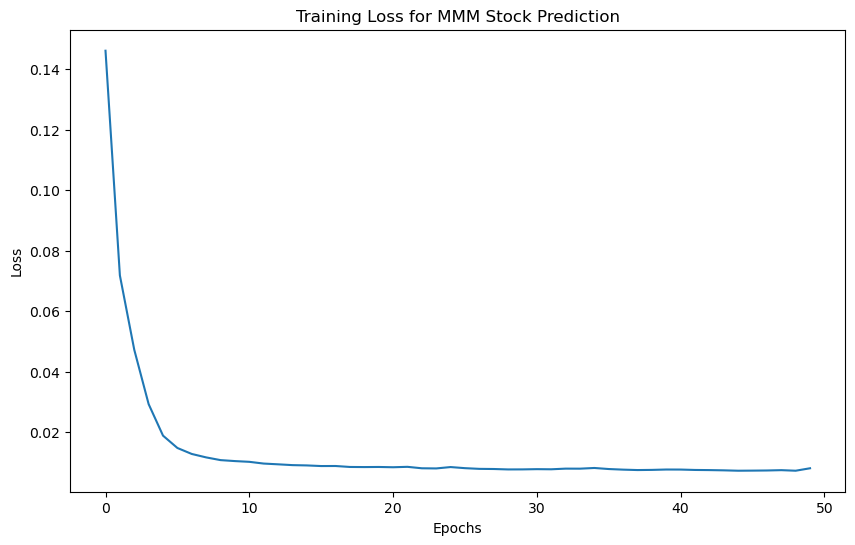

Predicting for MMM


[*********************100%***********************]  1 of 1 completed


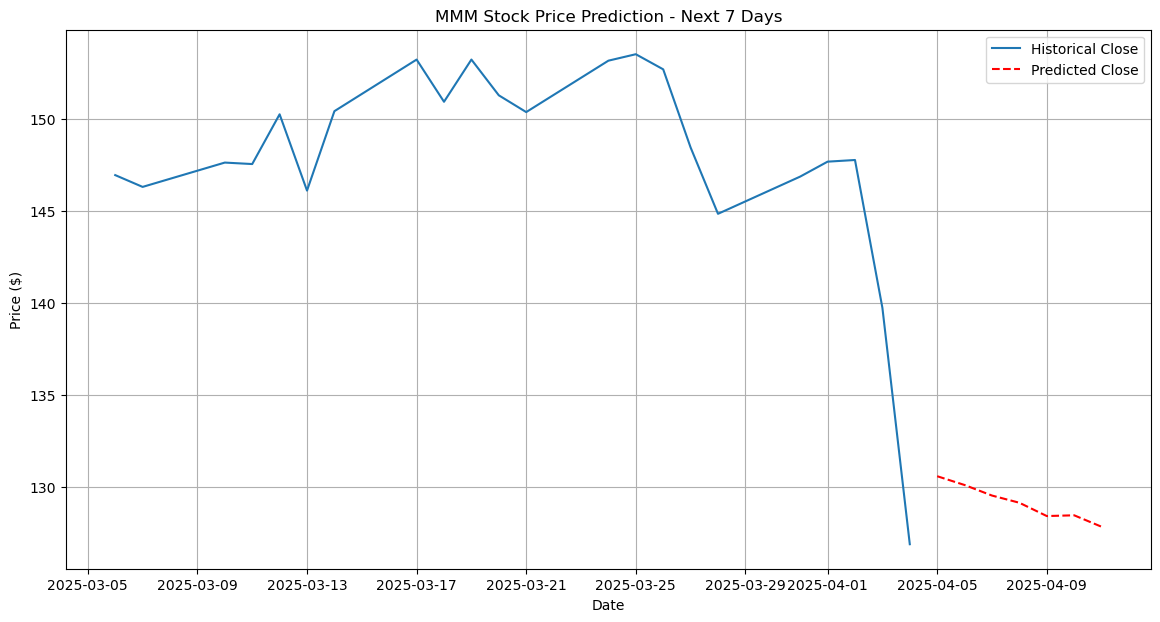


Predicted closing prices for the next 7 days:
2025-04-05: $130.60
2025-04-06: $130.12
2025-04-07: $129.55
2025-04-08: $129.16
2025-04-09: $128.44
2025-04-10: $128.48
2025-04-11: $127.86
Training model for IBM


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1876
Epoch [2/50], Loss: 0.0770
Epoch [3/50], Loss: 0.0521
Epoch [4/50], Loss: 0.0349
Epoch [5/50], Loss: 0.0233
Epoch [6/50], Loss: 0.0173
Epoch [7/50], Loss: 0.0140
Epoch [8/50], Loss: 0.0126
Epoch [9/50], Loss: 0.0115
Epoch [10/50], Loss: 0.0107
Epoch [11/50], Loss: 0.0101
Epoch [12/50], Loss: 0.0097
Epoch [13/50], Loss: 0.0092
Epoch [14/50], Loss: 0.0095
Epoch [15/50], Loss: 0.0091
Epoch [16/50], Loss: 0.0087
Epoch [17/50], Loss: 0.0086
Epoch [18/50], Loss: 0.0086
Epoch [19/50], Loss: 0.0086
Epoch [20/50], Loss: 0.0083
Epoch [21/50], Loss: 0.0081
Epoch [22/50], Loss: 0.0082
Epoch [23/50], Loss: 0.0082
Epoch [24/50], Loss: 0.0079
Epoch [25/50], Loss: 0.0080
Epoch [26/50], Loss: 0.0077
Epoch [27/50], Loss: 0.0079
Epoch [28/50], Loss: 0.0077
Epoch [29/50], Loss: 0.0077
Epoch [30/50], Loss: 0.0075
Epoch [31/50], Loss: 0.0078
Epoch [32/50], Loss: 0.0077
Epoch [33/50], Loss: 0.0079
Epoch [34/50], Loss: 0.0075
Epoch [35/50], Loss: 0.0076
Epoch [36/50], Loss: 0.0076
E

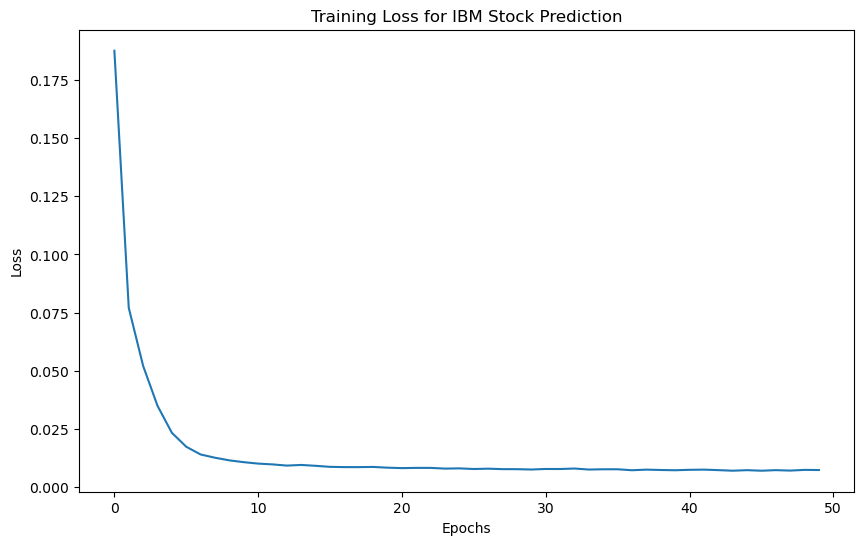

Predicting for IBM


[*********************100%***********************]  1 of 1 completed


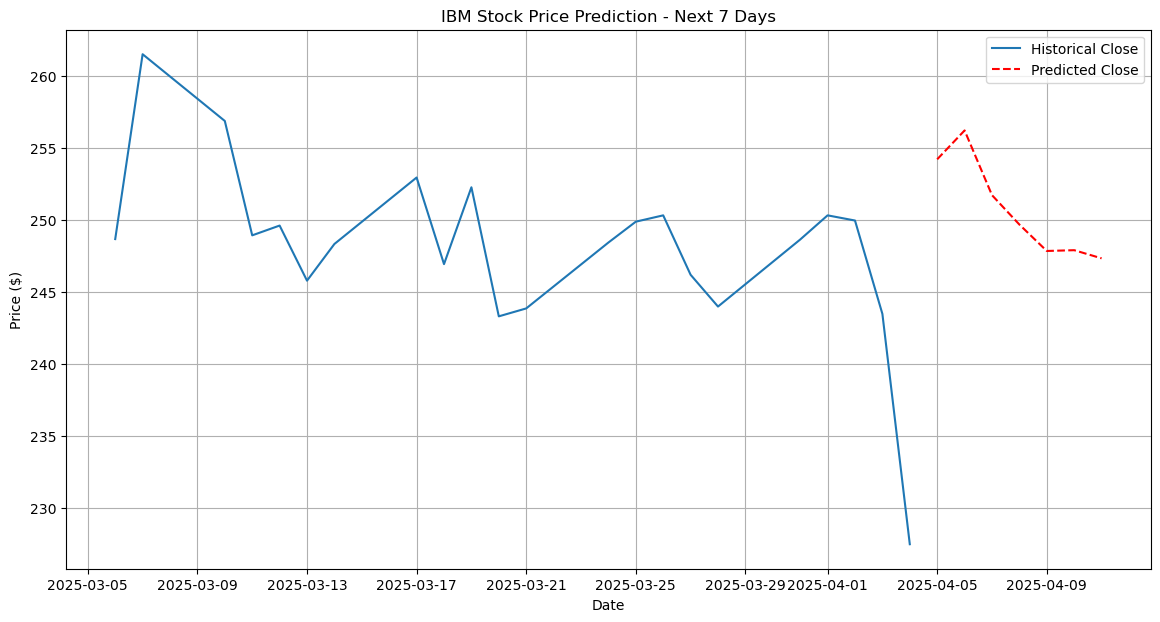


Predicted closing prices for the next 7 days:
2025-04-05: $254.24
2025-04-06: $256.24
2025-04-07: $251.74
2025-04-08: $249.70
2025-04-09: $247.86
2025-04-10: $247.92
2025-04-11: $247.35
Training model for MCD


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1649
Epoch [2/50], Loss: 0.0700
Epoch [3/50], Loss: 0.0468
Epoch [4/50], Loss: 0.0304
Epoch [5/50], Loss: 0.0204
Epoch [6/50], Loss: 0.0158
Epoch [7/50], Loss: 0.0132
Epoch [8/50], Loss: 0.0119
Epoch [9/50], Loss: 0.0117
Epoch [10/50], Loss: 0.0105
Epoch [11/50], Loss: 0.0099
Epoch [12/50], Loss: 0.0097
Epoch [13/50], Loss: 0.0097
Epoch [14/50], Loss: 0.0098
Epoch [15/50], Loss: 0.0095
Epoch [16/50], Loss: 0.0090
Epoch [17/50], Loss: 0.0088
Epoch [18/50], Loss: 0.0087
Epoch [19/50], Loss: 0.0091
Epoch [20/50], Loss: 0.0088
Epoch [21/50], Loss: 0.0087
Epoch [22/50], Loss: 0.0086
Epoch [23/50], Loss: 0.0085
Epoch [24/50], Loss: 0.0084
Epoch [25/50], Loss: 0.0084
Epoch [26/50], Loss: 0.0083
Epoch [27/50], Loss: 0.0083
Epoch [28/50], Loss: 0.0087
Epoch [29/50], Loss: 0.0081
Epoch [30/50], Loss: 0.0082
Epoch [31/50], Loss: 0.0082
Epoch [32/50], Loss: 0.0084
Epoch [33/50], Loss: 0.0080
Epoch [34/50], Loss: 0.0082
Epoch [35/50], Loss: 0.0081
Epoch [36/50], Loss: 0.0079
E

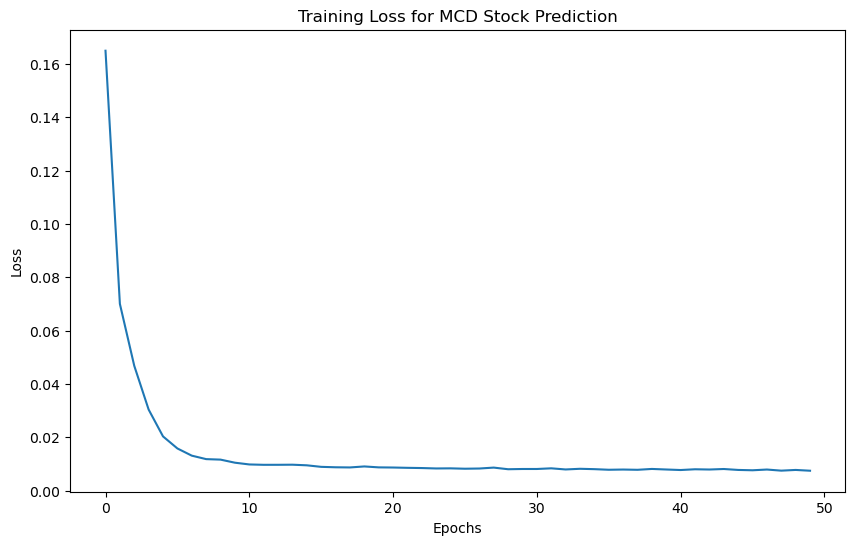

Predicting for MCD


[*********************100%***********************]  1 of 1 completed


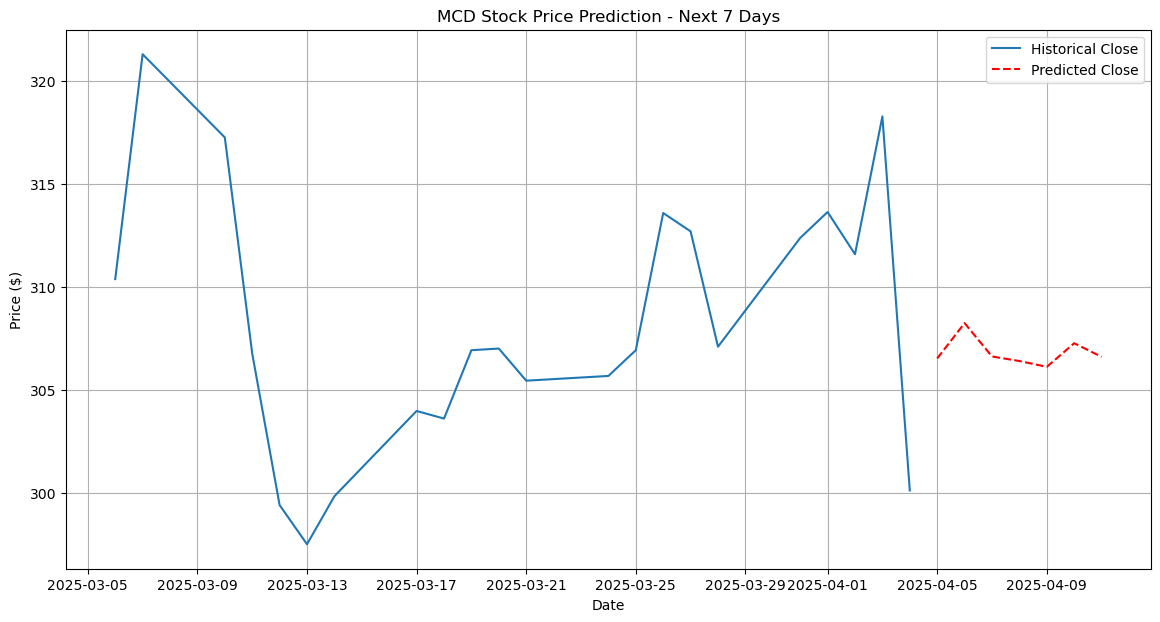


Predicted closing prices for the next 7 days:
2025-04-05: $306.52
2025-04-06: $308.23
2025-04-07: $306.62
2025-04-08: $306.39
2025-04-09: $306.11
2025-04-10: $307.26
2025-04-11: $306.60
Training model for DIS


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1755
Epoch [2/50], Loss: 0.0782
Epoch [3/50], Loss: 0.0525
Epoch [4/50], Loss: 0.0339
Epoch [5/50], Loss: 0.0243
Epoch [6/50], Loss: 0.0197
Epoch [7/50], Loss: 0.0177
Epoch [8/50], Loss: 0.0162
Epoch [9/50], Loss: 0.0154
Epoch [10/50], Loss: 0.0151
Epoch [11/50], Loss: 0.0145
Epoch [12/50], Loss: 0.0143
Epoch [13/50], Loss: 0.0137
Epoch [14/50], Loss: 0.0136
Epoch [15/50], Loss: 0.0135
Epoch [16/50], Loss: 0.0134
Epoch [17/50], Loss: 0.0133
Epoch [18/50], Loss: 0.0128
Epoch [19/50], Loss: 0.0125
Epoch [20/50], Loss: 0.0125
Epoch [21/50], Loss: 0.0127
Epoch [22/50], Loss: 0.0128
Epoch [23/50], Loss: 0.0123
Epoch [24/50], Loss: 0.0124
Epoch [25/50], Loss: 0.0124
Epoch [26/50], Loss: 0.0126
Epoch [27/50], Loss: 0.0125
Epoch [28/50], Loss: 0.0122
Epoch [29/50], Loss: 0.0119
Epoch [30/50], Loss: 0.0121
Epoch [31/50], Loss: 0.0126
Epoch [32/50], Loss: 0.0120
Epoch [33/50], Loss: 0.0121
Epoch [34/50], Loss: 0.0122
Epoch [35/50], Loss: 0.0120
Epoch [36/50], Loss: 0.0119
E

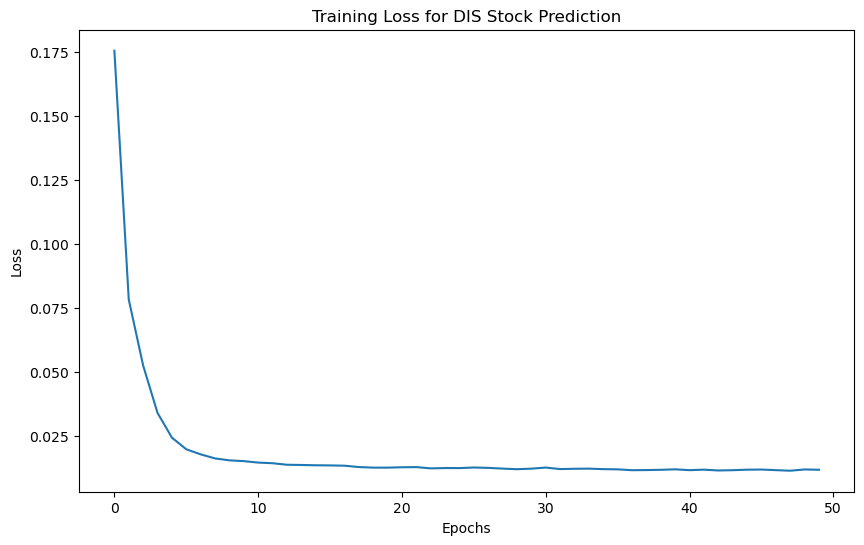

Predicting for DIS


[*********************100%***********************]  1 of 1 completed


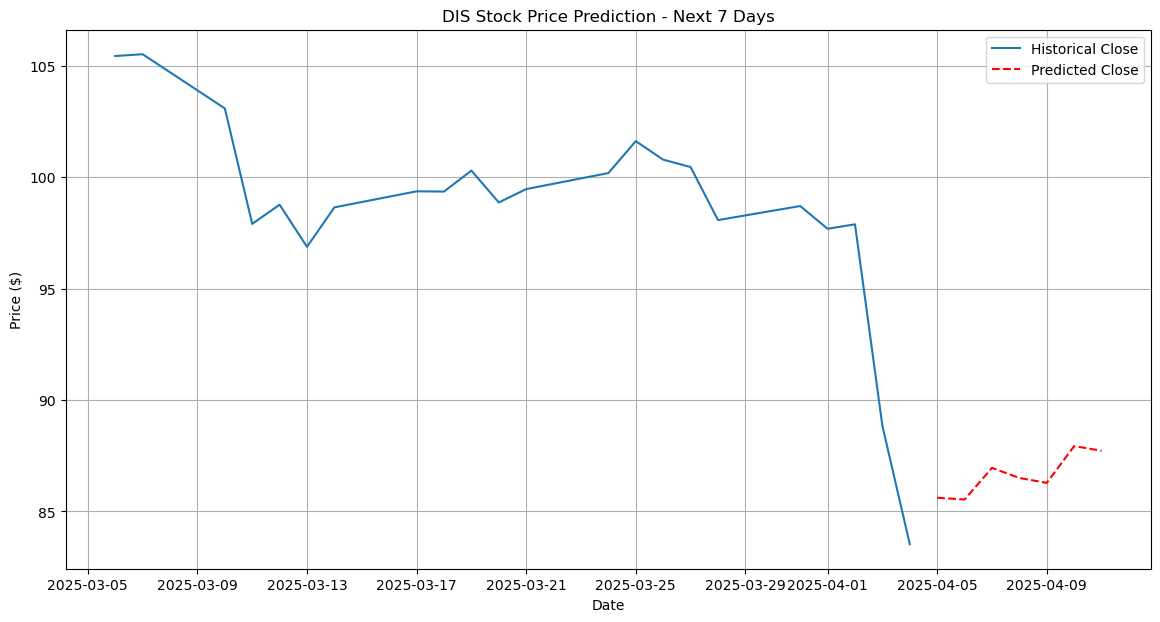


Predicted closing prices for the next 7 days:
2025-04-05: $85.62
2025-04-06: $85.53
2025-04-07: $86.95
2025-04-08: $86.50
2025-04-09: $86.28
2025-04-10: $87.93
2025-04-11: $87.72
Training model for PG


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1635
Epoch [2/50], Loss: 0.0743
Epoch [3/50], Loss: 0.0512
Epoch [4/50], Loss: 0.0311
Epoch [5/50], Loss: 0.0210
Epoch [6/50], Loss: 0.0169
Epoch [7/50], Loss: 0.0143
Epoch [8/50], Loss: 0.0133
Epoch [9/50], Loss: 0.0125
Epoch [10/50], Loss: 0.0118
Epoch [11/50], Loss: 0.0117
Epoch [12/50], Loss: 0.0118
Epoch [13/50], Loss: 0.0116
Epoch [14/50], Loss: 0.0112
Epoch [15/50], Loss: 0.0112
Epoch [16/50], Loss: 0.0108
Epoch [17/50], Loss: 0.0107
Epoch [18/50], Loss: 0.0109
Epoch [19/50], Loss: 0.0106
Epoch [20/50], Loss: 0.0105
Epoch [21/50], Loss: 0.0105
Epoch [22/50], Loss: 0.0103
Epoch [23/50], Loss: 0.0103
Epoch [24/50], Loss: 0.0105
Epoch [25/50], Loss: 0.0101
Epoch [26/50], Loss: 0.0103
Epoch [27/50], Loss: 0.0105
Epoch [28/50], Loss: 0.0103
Epoch [29/50], Loss: 0.0103
Epoch [30/50], Loss: 0.0100
Epoch [31/50], Loss: 0.0099
Epoch [32/50], Loss: 0.0102
Epoch [33/50], Loss: 0.0101
Epoch [34/50], Loss: 0.0102
Epoch [35/50], Loss: 0.0099
Epoch [36/50], Loss: 0.0100
E

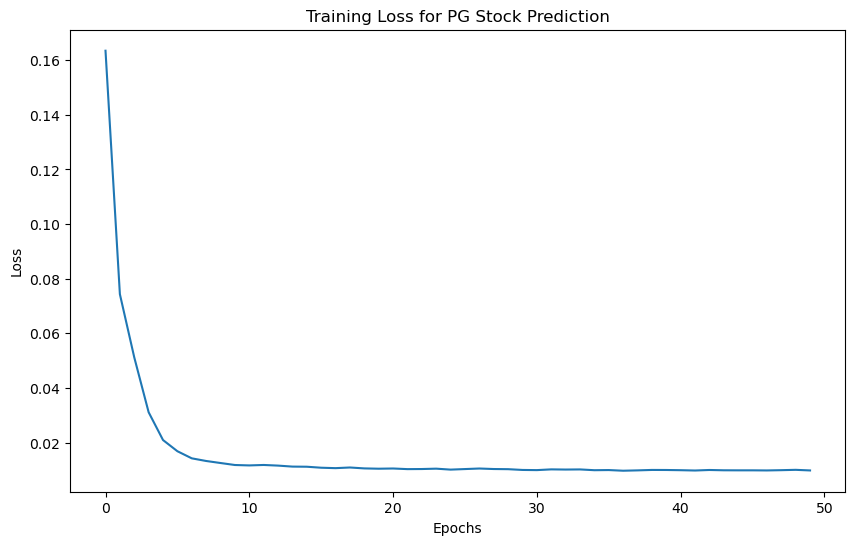

Predicting for PG


[*********************100%***********************]  1 of 1 completed


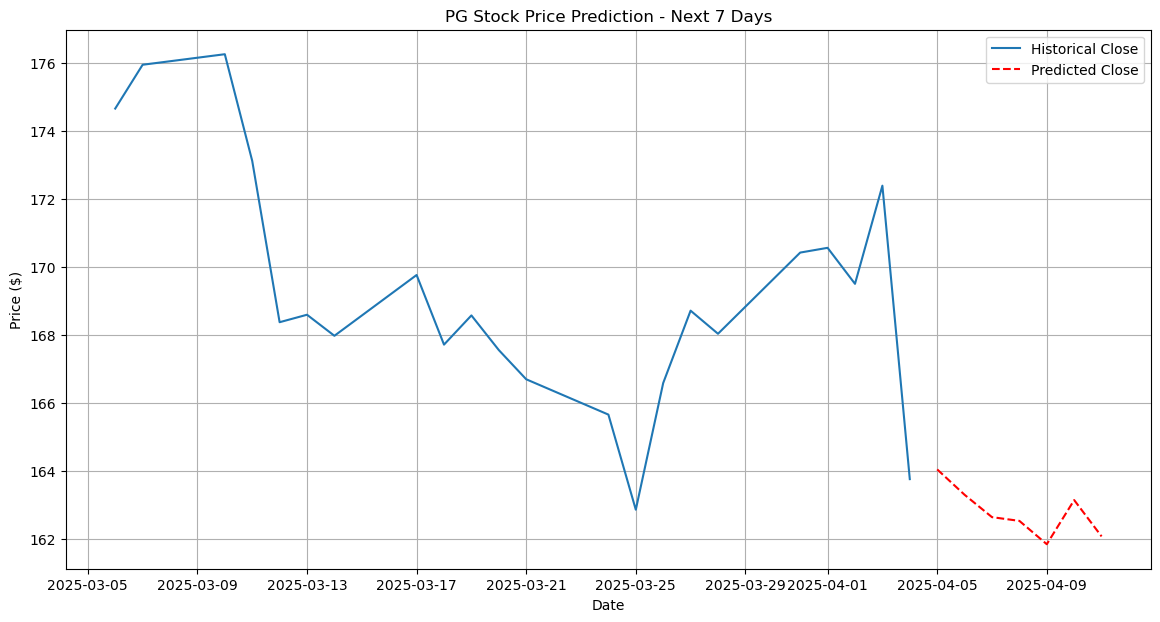


Predicted closing prices for the next 7 days:
2025-04-05: $164.04
2025-04-06: $163.29
2025-04-07: $162.63
2025-04-08: $162.52
2025-04-09: $161.83
2025-04-10: $163.13
2025-04-11: $162.06
Training model for TRMB


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1516
Epoch [2/50], Loss: 0.0667
Epoch [3/50], Loss: 0.0414
Epoch [4/50], Loss: 0.0250
Epoch [5/50], Loss: 0.0163
Epoch [6/50], Loss: 0.0120
Epoch [7/50], Loss: 0.0102
Epoch [8/50], Loss: 0.0091
Epoch [9/50], Loss: 0.0084
Epoch [10/50], Loss: 0.0079
Epoch [11/50], Loss: 0.0076
Epoch [12/50], Loss: 0.0075
Epoch [13/50], Loss: 0.0073
Epoch [14/50], Loss: 0.0070
Epoch [15/50], Loss: 0.0069
Epoch [16/50], Loss: 0.0072
Epoch [17/50], Loss: 0.0066
Epoch [18/50], Loss: 0.0065
Epoch [19/50], Loss: 0.0063
Epoch [20/50], Loss: 0.0063
Epoch [21/50], Loss: 0.0063
Epoch [22/50], Loss: 0.0059
Epoch [23/50], Loss: 0.0061
Epoch [24/50], Loss: 0.0061
Epoch [25/50], Loss: 0.0061
Epoch [26/50], Loss: 0.0058
Epoch [27/50], Loss: 0.0060
Epoch [28/50], Loss: 0.0055
Epoch [29/50], Loss: 0.0057
Epoch [30/50], Loss: 0.0055
Epoch [31/50], Loss: 0.0055
Epoch [32/50], Loss: 0.0056
Epoch [33/50], Loss: 0.0054
Epoch [34/50], Loss: 0.0053
Epoch [35/50], Loss: 0.0055
Epoch [36/50], Loss: 0.0056
E

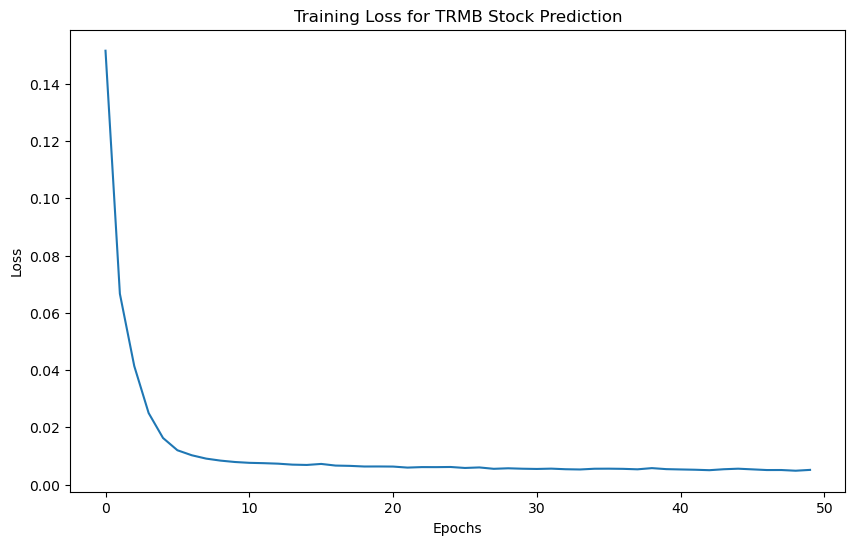

Predicting for TRMB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TRMB']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


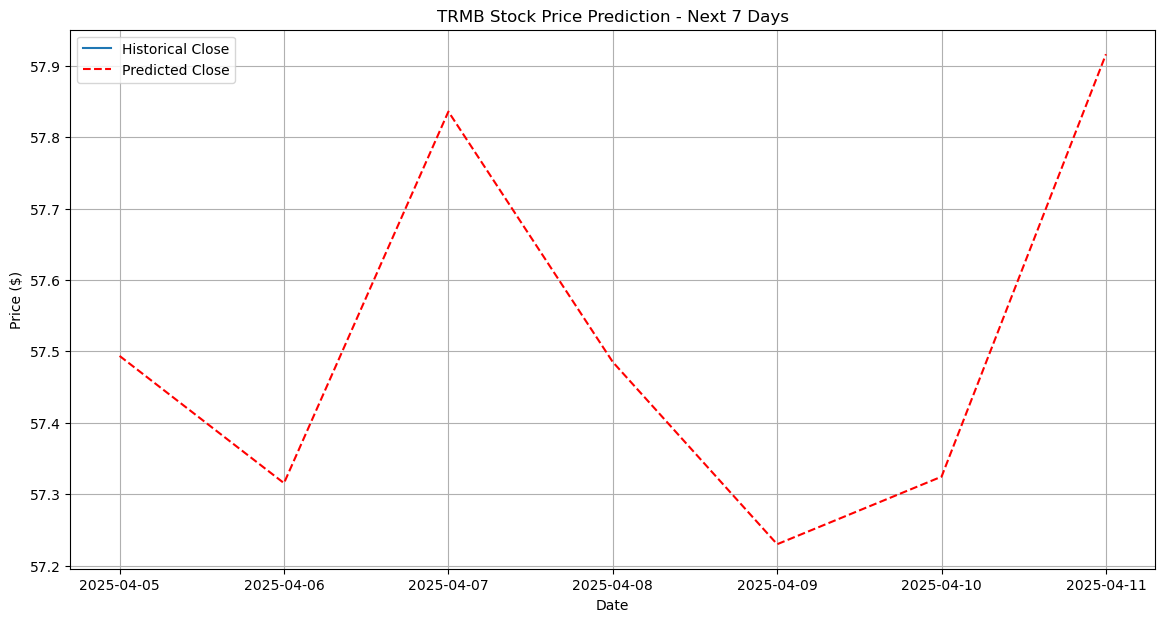


Predicted closing prices for the next 7 days:
2025-04-05: $57.49
2025-04-06: $57.32
2025-04-07: $57.84
2025-04-08: $57.49
2025-04-09: $57.23
2025-04-10: $57.32
2025-04-11: $57.92
Training model for ORCL


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.2040
Epoch [2/50], Loss: 0.0804
Epoch [3/50], Loss: 0.0553
Epoch [4/50], Loss: 0.0372
Epoch [5/50], Loss: 0.0253
Epoch [6/50], Loss: 0.0191
Epoch [7/50], Loss: 0.0165
Epoch [8/50], Loss: 0.0146
Epoch [9/50], Loss: 0.0137
Epoch [10/50], Loss: 0.0129
Epoch [11/50], Loss: 0.0126
Epoch [12/50], Loss: 0.0119
Epoch [13/50], Loss: 0.0118
Epoch [14/50], Loss: 0.0113
Epoch [15/50], Loss: 0.0111
Epoch [16/50], Loss: 0.0112
Epoch [17/50], Loss: 0.0111
Epoch [18/50], Loss: 0.0107
Epoch [19/50], Loss: 0.0109
Epoch [20/50], Loss: 0.0106
Epoch [21/50], Loss: 0.0105
Epoch [22/50], Loss: 0.0105
Epoch [23/50], Loss: 0.0105
Epoch [24/50], Loss: 0.0103
Epoch [25/50], Loss: 0.0103
Epoch [26/50], Loss: 0.0105
Epoch [27/50], Loss: 0.0104
Epoch [28/50], Loss: 0.0103
Epoch [29/50], Loss: 0.0101
Epoch [30/50], Loss: 0.0101
Epoch [31/50], Loss: 0.0102
Epoch [32/50], Loss: 0.0099
Epoch [33/50], Loss: 0.0101
Epoch [34/50], Loss: 0.0100
Epoch [35/50], Loss: 0.0099
Epoch [36/50], Loss: 0.0099
E

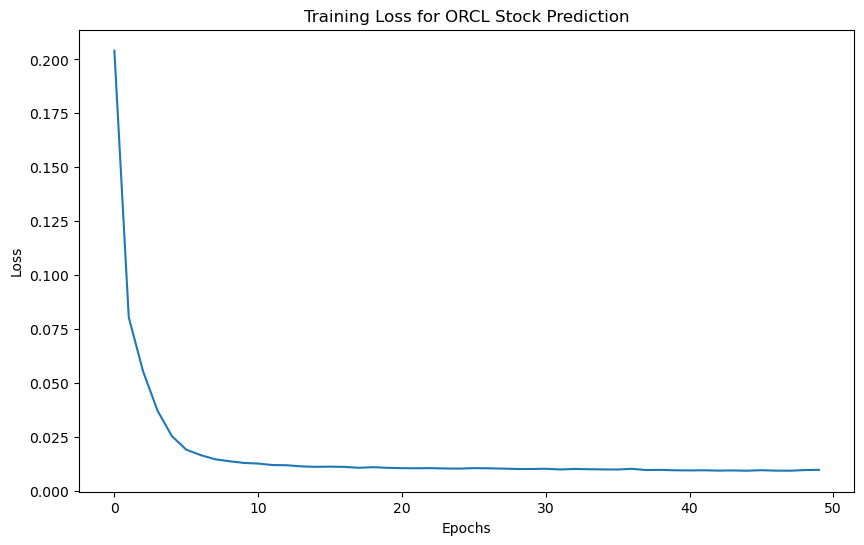

Predicting for ORCL


[*********************100%***********************]  1 of 1 completed


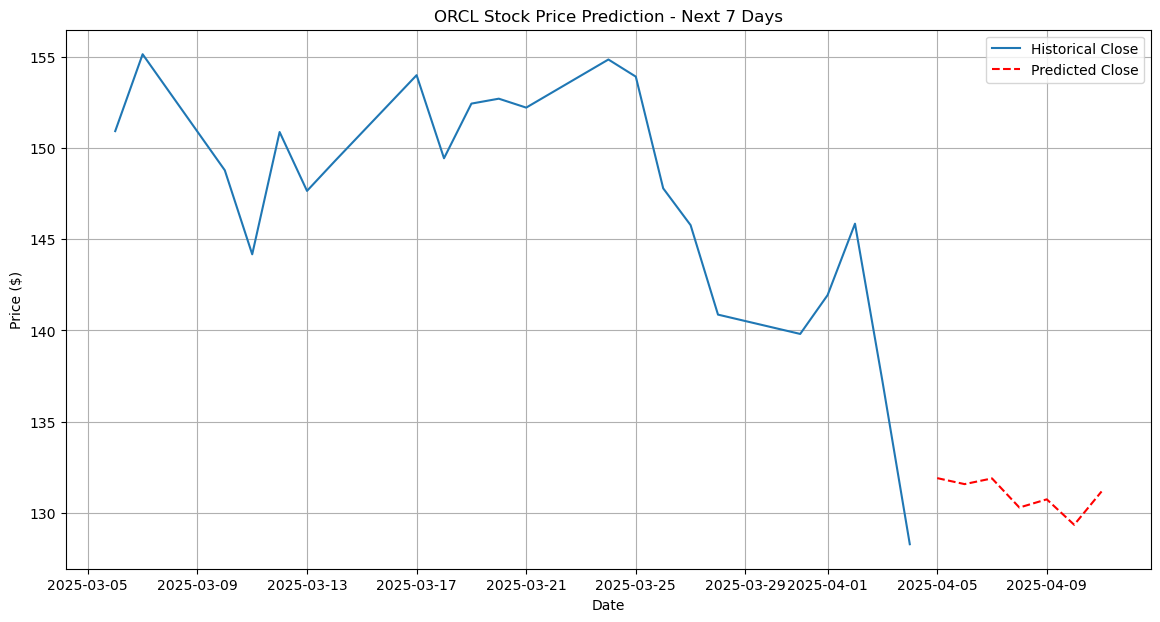


Predicted closing prices for the next 7 days:
2025-04-05: $131.90
2025-04-06: $131.57
2025-04-07: $131.88
2025-04-08: $130.28
2025-04-09: $130.73
2025-04-10: $129.34
2025-04-11: $131.17
Training model for CSCO


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1374
Epoch [2/50], Loss: 0.0668
Epoch [3/50], Loss: 0.0434
Epoch [4/50], Loss: 0.0277
Epoch [5/50], Loss: 0.0198
Epoch [6/50], Loss: 0.0168
Epoch [7/50], Loss: 0.0152
Epoch [8/50], Loss: 0.0144
Epoch [9/50], Loss: 0.0141
Epoch [10/50], Loss: 0.0142
Epoch [11/50], Loss: 0.0134
Epoch [12/50], Loss: 0.0134
Epoch [13/50], Loss: 0.0132
Epoch [14/50], Loss: 0.0131
Epoch [15/50], Loss: 0.0131
Epoch [16/50], Loss: 0.0129
Epoch [17/50], Loss: 0.0128
Epoch [18/50], Loss: 0.0127
Epoch [19/50], Loss: 0.0123
Epoch [20/50], Loss: 0.0124
Epoch [21/50], Loss: 0.0125
Epoch [22/50], Loss: 0.0123
Epoch [23/50], Loss: 0.0123
Epoch [24/50], Loss: 0.0125
Epoch [25/50], Loss: 0.0122
Epoch [26/50], Loss: 0.0121
Epoch [27/50], Loss: 0.0118
Epoch [28/50], Loss: 0.0120
Epoch [29/50], Loss: 0.0118
Epoch [30/50], Loss: 0.0118
Epoch [31/50], Loss: 0.0119
Epoch [32/50], Loss: 0.0119
Epoch [33/50], Loss: 0.0118
Epoch [34/50], Loss: 0.0117
Epoch [35/50], Loss: 0.0116
Epoch [36/50], Loss: 0.0114
E

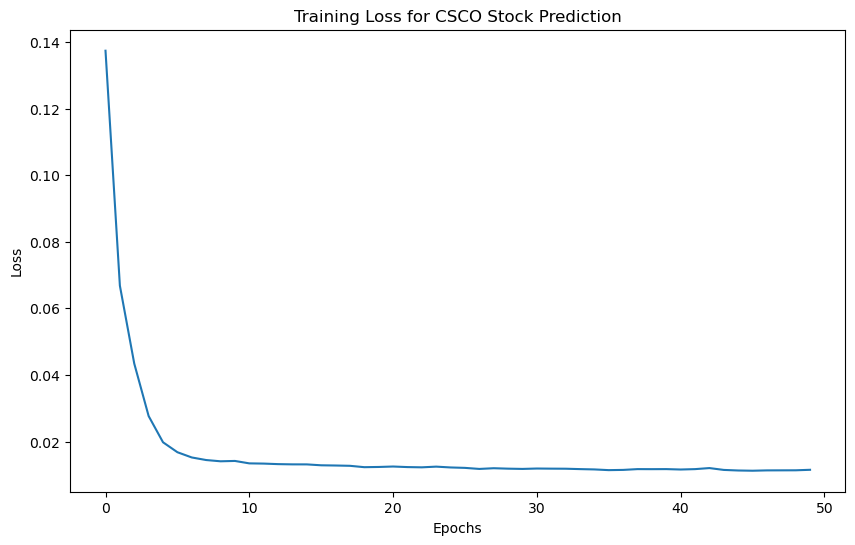

Predicting for CSCO


[*********************100%***********************]  1 of 1 completed


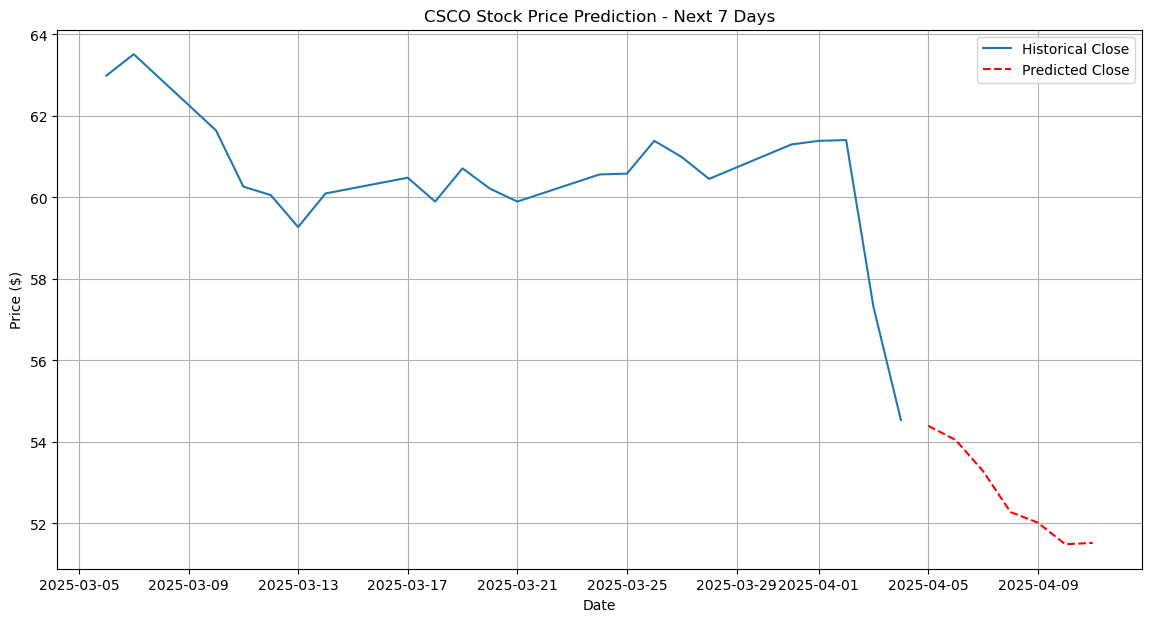


Predicted closing prices for the next 7 days:
2025-04-05: $54.40
2025-04-06: $54.05
2025-04-07: $53.28
2025-04-08: $52.28
2025-04-09: $52.02
2025-04-10: $51.49
2025-04-11: $51.52
Training model for CMCSA


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1449
Epoch [2/50], Loss: 0.0695
Epoch [3/50], Loss: 0.0442
Epoch [4/50], Loss: 0.0273
Epoch [5/50], Loss: 0.0194
Epoch [6/50], Loss: 0.0163
Epoch [7/50], Loss: 0.0151
Epoch [8/50], Loss: 0.0142
Epoch [9/50], Loss: 0.0137
Epoch [10/50], Loss: 0.0135
Epoch [11/50], Loss: 0.0134
Epoch [12/50], Loss: 0.0133
Epoch [13/50], Loss: 0.0129
Epoch [14/50], Loss: 0.0126
Epoch [15/50], Loss: 0.0125
Epoch [16/50], Loss: 0.0127
Epoch [17/50], Loss: 0.0127
Epoch [18/50], Loss: 0.0122
Epoch [19/50], Loss: 0.0125
Epoch [20/50], Loss: 0.0124
Epoch [21/50], Loss: 0.0121
Epoch [22/50], Loss: 0.0120
Epoch [23/50], Loss: 0.0122
Epoch [24/50], Loss: 0.0120
Epoch [25/50], Loss: 0.0131
Epoch [26/50], Loss: 0.0122
Epoch [27/50], Loss: 0.0117
Epoch [28/50], Loss: 0.0117
Epoch [29/50], Loss: 0.0117
Epoch [30/50], Loss: 0.0118
Epoch [31/50], Loss: 0.0118
Epoch [32/50], Loss: 0.0117
Epoch [33/50], Loss: 0.0116
Epoch [34/50], Loss: 0.0118
Epoch [35/50], Loss: 0.0117
Epoch [36/50], Loss: 0.0117
E

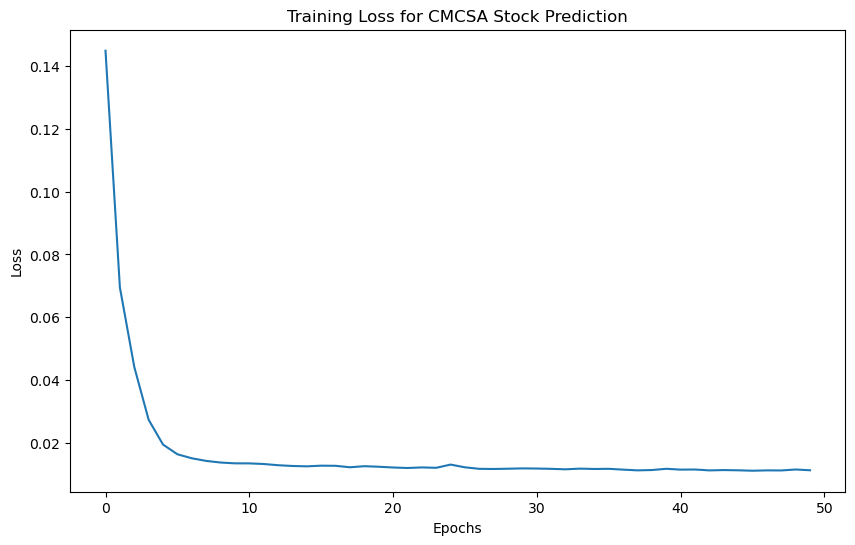

[*********************100%***********************]  1 of 1 completed

Predicting for CMCSA


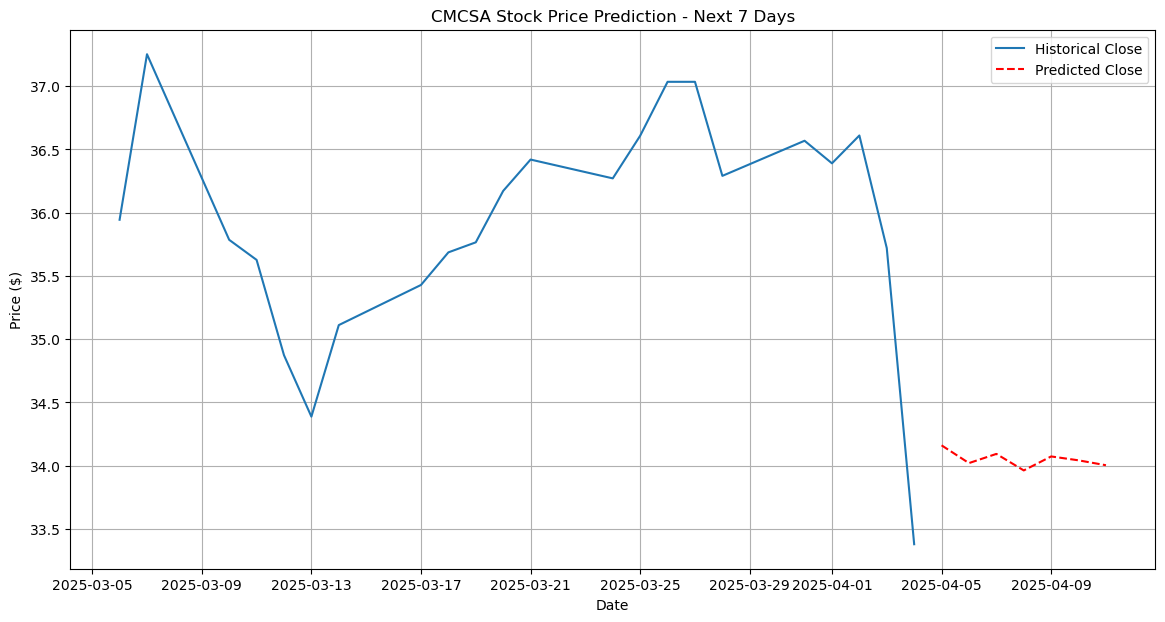


Predicted closing prices for the next 7 days:
2025-04-05: $34.16
2025-04-06: $34.02
2025-04-07: $34.09
2025-04-08: $33.96
2025-04-09: $34.07
2025-04-10: $34.04
2025-04-11: $34.00
Training model for QS


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.2398
Epoch [2/50], Loss: 0.1074
Epoch [3/50], Loss: 0.0785
Epoch [4/50], Loss: 0.0641
Epoch [5/50], Loss: 0.0530
Epoch [6/50], Loss: 0.0424
Epoch [7/50], Loss: 0.0328
Epoch [8/50], Loss: 0.0280
Epoch [9/50], Loss: 0.0221
Epoch [10/50], Loss: 0.0198
Epoch [11/50], Loss: 0.0192
Epoch [12/50], Loss: 0.0168
Epoch [13/50], Loss: 0.0158
Epoch [14/50], Loss: 0.0154
Epoch [15/50], Loss: 0.0149
Epoch [16/50], Loss: 0.0143
Epoch [17/50], Loss: 0.0153
Epoch [18/50], Loss: 0.0136
Epoch [19/50], Loss: 0.0142
Epoch [20/50], Loss: 0.0133
Epoch [21/50], Loss: 0.0136
Epoch [22/50], Loss: 0.0126
Epoch [23/50], Loss: 0.0132
Epoch [24/50], Loss: 0.0134
Epoch [25/50], Loss: 0.0125
Epoch [26/50], Loss: 0.0118
Epoch [27/50], Loss: 0.0116
Epoch [28/50], Loss: 0.0116
Epoch [29/50], Loss: 0.0114
Epoch [30/50], Loss: 0.0148
Epoch [31/50], Loss: 0.0128
Epoch [32/50], Loss: 0.0137
Epoch [33/50], Loss: 0.0130
Epoch [34/50], Loss: 0.0124
Epoch [35/50], Loss: 0.0117
Epoch [36/50], Loss: 0.0116
E

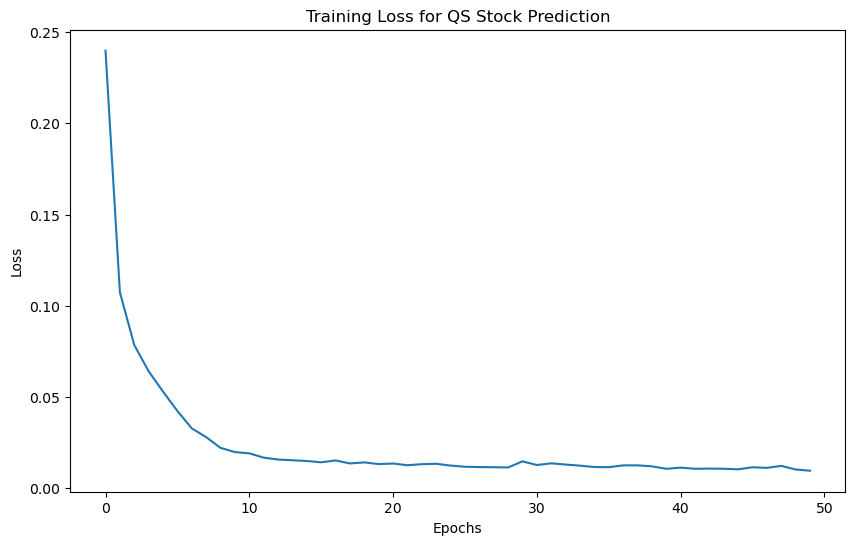

[*********************100%***********************]  1 of 1 completed

Predicting for QS


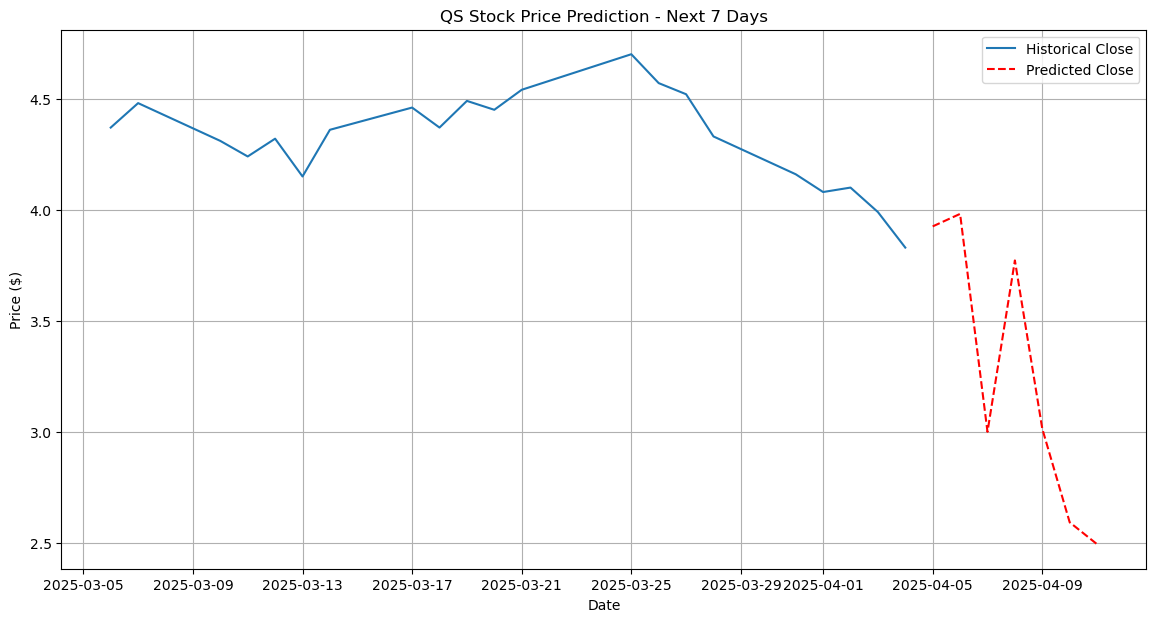


Predicted closing prices for the next 7 days:
2025-04-05: $3.93
2025-04-06: $3.98
2025-04-07: $3.00
2025-04-08: $3.77
2025-04-09: $3.01
2025-04-10: $2.59
2025-04-11: $2.50
Training model for SLDP


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.2676
Epoch [2/50], Loss: 0.1008
Epoch [3/50], Loss: 0.0778
Epoch [4/50], Loss: 0.0633
Epoch [5/50], Loss: 0.0519
Epoch [6/50], Loss: 0.0420
Epoch [7/50], Loss: 0.0329
Epoch [8/50], Loss: 0.0262
Epoch [9/50], Loss: 0.0215
Epoch [10/50], Loss: 0.0188
Epoch [11/50], Loss: 0.0166
Epoch [12/50], Loss: 0.0151
Epoch [13/50], Loss: 0.0138
Epoch [14/50], Loss: 0.0129
Epoch [15/50], Loss: 0.0127
Epoch [16/50], Loss: 0.0119
Epoch [17/50], Loss: 0.0112
Epoch [18/50], Loss: 0.0112
Epoch [19/50], Loss: 0.0114
Epoch [20/50], Loss: 0.0113
Epoch [21/50], Loss: 0.0106
Epoch [22/50], Loss: 0.0098
Epoch [23/50], Loss: 0.0104
Epoch [24/50], Loss: 0.0101
Epoch [25/50], Loss: 0.0098
Epoch [26/50], Loss: 0.0093
Epoch [27/50], Loss: 0.0095
Epoch [28/50], Loss: 0.0093
Epoch [29/50], Loss: 0.0090
Epoch [30/50], Loss: 0.0090
Epoch [31/50], Loss: 0.0088
Epoch [32/50], Loss: 0.0085
Epoch [33/50], Loss: 0.0087
Epoch [34/50], Loss: 0.0091
Epoch [35/50], Loss: 0.0086
Epoch [36/50], Loss: 0.0090
E

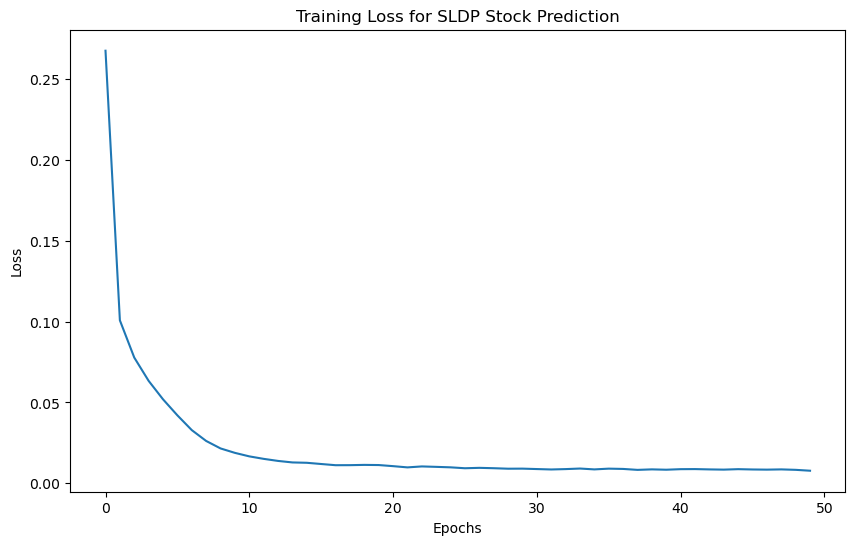

[*********************100%***********************]  1 of 1 completed

Predicting for SLDP


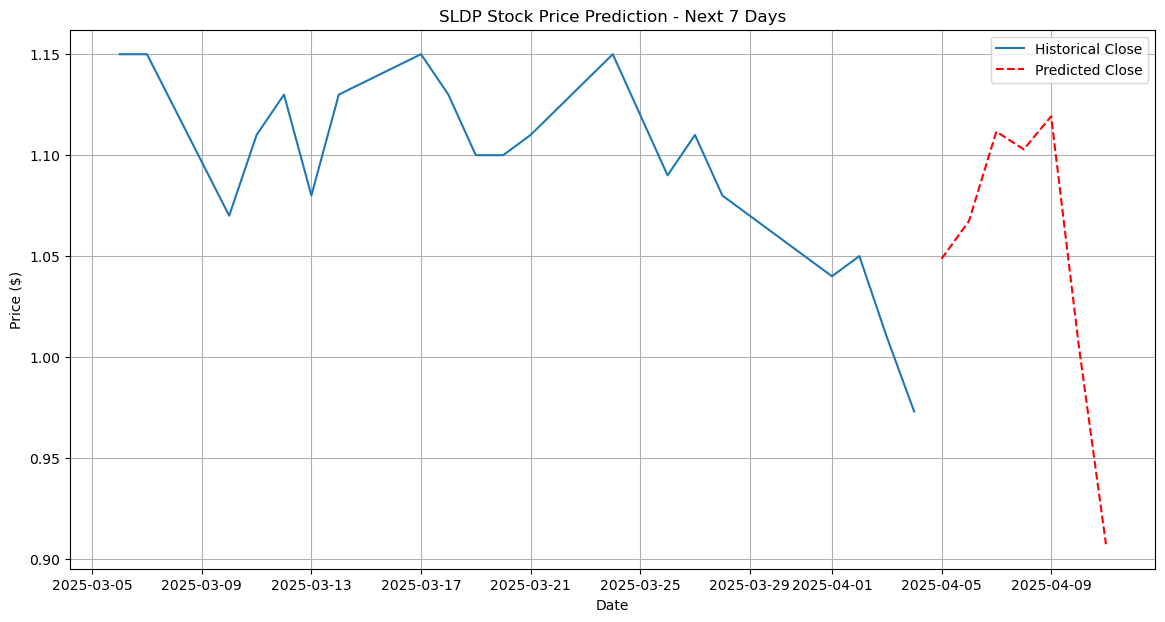

[*********************100%***********************]  1 of 1 completed


Predicted closing prices for the next 7 days:
2025-04-05: $1.05
2025-04-06: $1.07
2025-04-07: $1.11
2025-04-08: $1.10
2025-04-09: $1.12
2025-04-10: $1.01
2025-04-11: $0.91
Training model for LCID


Epoch [1/50], Loss: 0.2228
Epoch [2/50], Loss: 0.1042
Epoch [3/50], Loss: 0.0787
Epoch [4/50], Loss: 0.0651
Epoch [5/50], Loss: 0.0526
Epoch [6/50], Loss: 0.0403
Epoch [7/50], Loss: 0.0316
Epoch [8/50], Loss: 0.0266
Epoch [9/50], Loss: 0.0233
Epoch [10/50], Loss: 0.0209
Epoch [11/50], Loss: 0.0196
Epoch [12/50], Loss: 0.0184
Epoch [13/50], Loss: 0.0180
Epoch [14/50], Loss: 0.0171
Epoch [15/50], Loss: 0.0168
Epoch [16/50], Loss: 0.0165
Epoch [17/50], Loss: 0.0161
Epoch [18/50], Loss: 0.0154
Epoch [19/50], Loss: 0.0160
Epoch [20/50], Loss: 0.0154
Epoch [21/50], Loss: 0.0156
Epoch [22/50], Loss: 0.0146
Epoch [23/50], Loss: 0.0143
Epoch [24/50], Loss: 0.0144
Epoch [25/50], Loss: 0.0137
Epoch [26/50], Loss: 0.0139
Epoch [27/50], Loss: 0.0139
Epoch [28/50], Loss: 0.0134
Epoch [29/50], Loss: 0.0135
Epoch [30/50], Loss: 0.0131
Epoch [31/50], Loss: 0.0130
Epoch [32/50], Loss: 0.0133
Epoch [33/50], Loss: 0.0131
Epoch [34/50], Loss: 0.0130
Epoch [35/50], Loss: 0.0128
Epoch [36/50], Loss: 0.0125
E

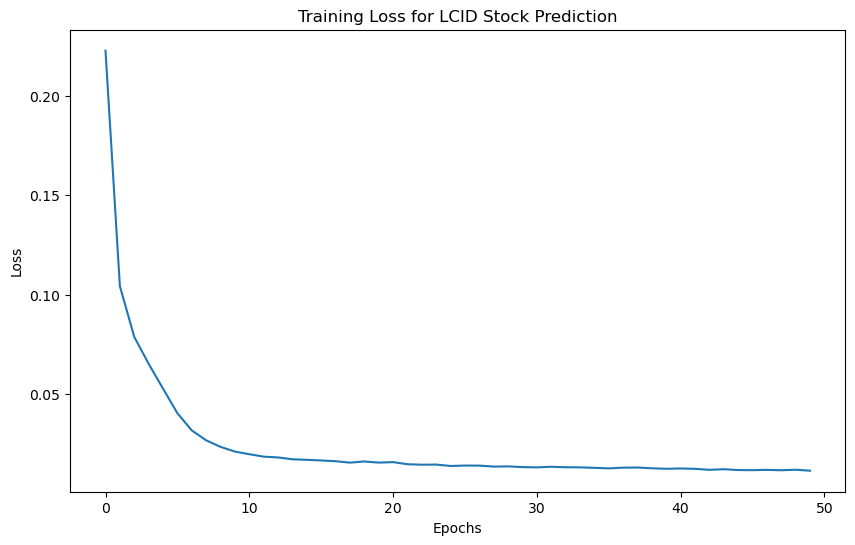

[*********************100%***********************]  1 of 1 completed

Predicting for LCID


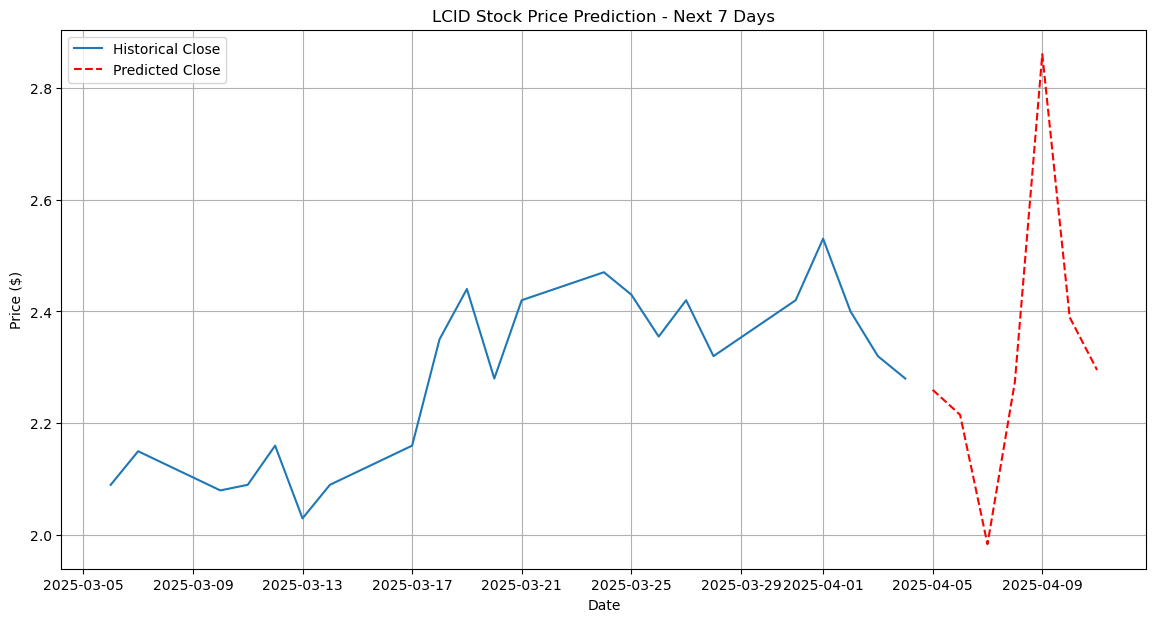


Predicted closing prices for the next 7 days:
2025-04-05: $2.26
2025-04-06: $2.22
2025-04-07: $1.98
2025-04-08: $2.27
2025-04-09: $2.86
2025-04-10: $2.39
2025-04-11: $2.30
Training model for UVXY


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.2303
Epoch [2/50], Loss: 0.0760
Epoch [3/50], Loss: 0.0535
Epoch [4/50], Loss: 0.0366
Epoch [5/50], Loss: 0.0244
Epoch [6/50], Loss: 0.0179
Epoch [7/50], Loss: 0.0146
Epoch [8/50], Loss: 0.0129
Epoch [9/50], Loss: 0.0120
Epoch [10/50], Loss: 0.0110
Epoch [11/50], Loss: 0.0103
Epoch [12/50], Loss: 0.0100
Epoch [13/50], Loss: 0.0096
Epoch [14/50], Loss: 0.0098
Epoch [15/50], Loss: 0.0090
Epoch [16/50], Loss: 0.0086
Epoch [17/50], Loss: 0.0084
Epoch [18/50], Loss: 0.0084
Epoch [19/50], Loss: 0.0080
Epoch [20/50], Loss: 0.0083
Epoch [21/50], Loss: 0.0079
Epoch [22/50], Loss: 0.0077
Epoch [23/50], Loss: 0.0083
Epoch [24/50], Loss: 0.0082
Epoch [25/50], Loss: 0.0078
Epoch [26/50], Loss: 0.0074
Epoch [27/50], Loss: 0.0072
Epoch [28/50], Loss: 0.0076
Epoch [29/50], Loss: 0.0072
Epoch [30/50], Loss: 0.0074
Epoch [31/50], Loss: 0.0070
Epoch [32/50], Loss: 0.0068
Epoch [33/50], Loss: 0.0071
Epoch [34/50], Loss: 0.0072
Epoch [35/50], Loss: 0.0068
Epoch [36/50], Loss: 0.0067
E

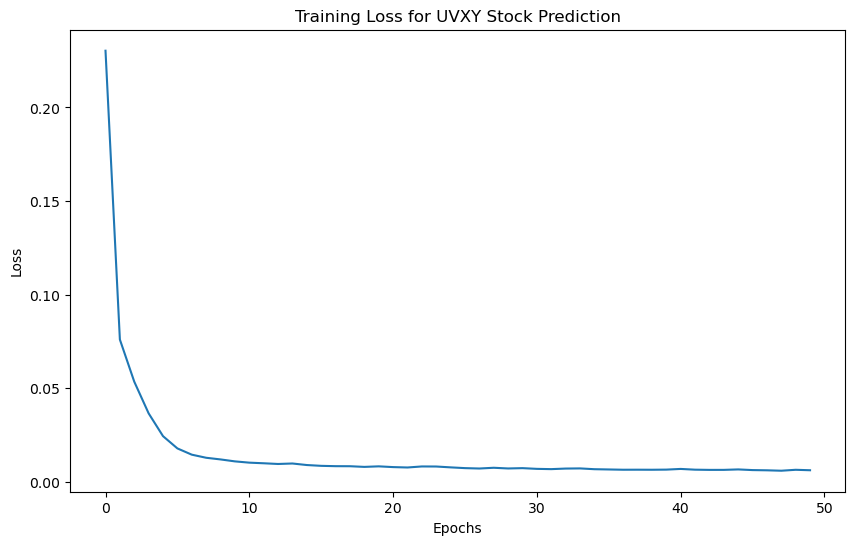

[*********************100%***********************]  1 of 1 completed

Predicting for UVXY


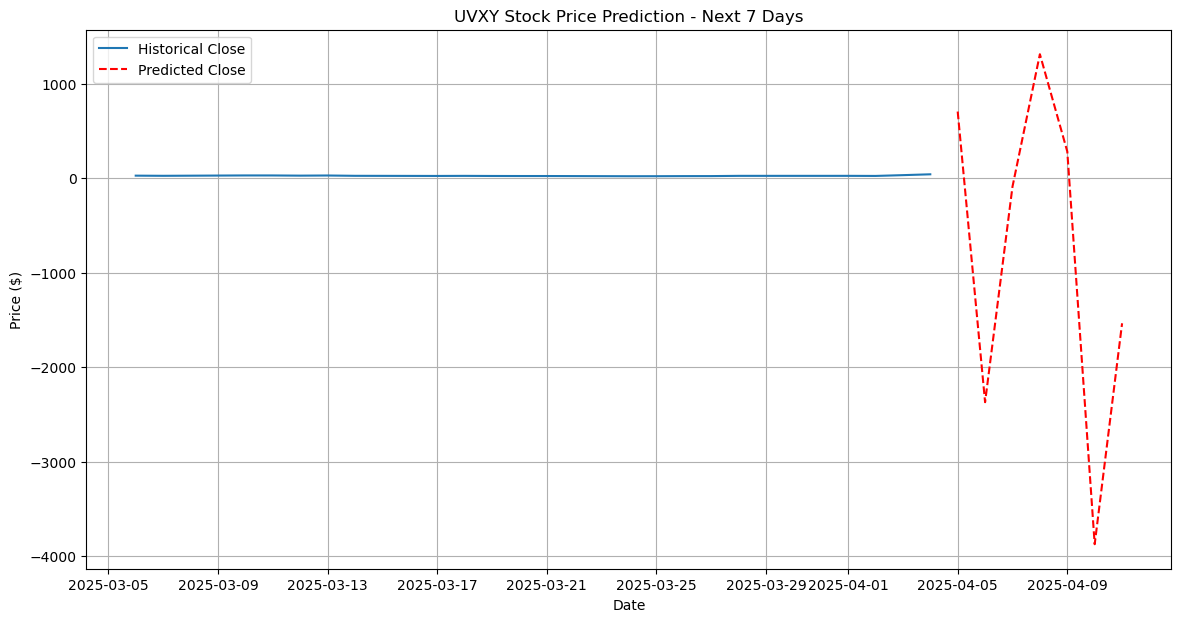


Predicted closing prices for the next 7 days:
2025-04-05: $703.89
2025-04-06: $-2372.00
2025-04-07: $-90.69
2025-04-08: $1310.55
2025-04-09: $280.98
2025-04-10: $-3874.89
2025-04-11: $-1536.90
Training model for VXX


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.2046
Epoch [2/50], Loss: 0.0731
Epoch [3/50], Loss: 0.0517
Epoch [4/50], Loss: 0.0324
Epoch [5/50], Loss: 0.0207
Epoch [6/50], Loss: 0.0147
Epoch [7/50], Loss: 0.0124
Epoch [8/50], Loss: 0.0108
Epoch [9/50], Loss: 0.0104
Epoch [10/50], Loss: 0.0096
Epoch [11/50], Loss: 0.0091
Epoch [12/50], Loss: 0.0091
Epoch [13/50], Loss: 0.0082
Epoch [14/50], Loss: 0.0082
Epoch [15/50], Loss: 0.0078
Epoch [16/50], Loss: 0.0078
Epoch [17/50], Loss: 0.0090
Epoch [18/50], Loss: 0.0084
Epoch [19/50], Loss: 0.0076
Epoch [20/50], Loss: 0.0072
Epoch [21/50], Loss: 0.0071
Epoch [22/50], Loss: 0.0073
Epoch [23/50], Loss: 0.0071
Epoch [24/50], Loss: 0.0079
Epoch [25/50], Loss: 0.0070
Epoch [26/50], Loss: 0.0067
Epoch [27/50], Loss: 0.0067
Epoch [28/50], Loss: 0.0064
Epoch [29/50], Loss: 0.0067
Epoch [30/50], Loss: 0.0064
Epoch [31/50], Loss: 0.0062
Epoch [32/50], Loss: 0.0062
Epoch [33/50], Loss: 0.0063
Epoch [34/50], Loss: 0.0063
Epoch [35/50], Loss: 0.0063
Epoch [36/50], Loss: 0.0071
E

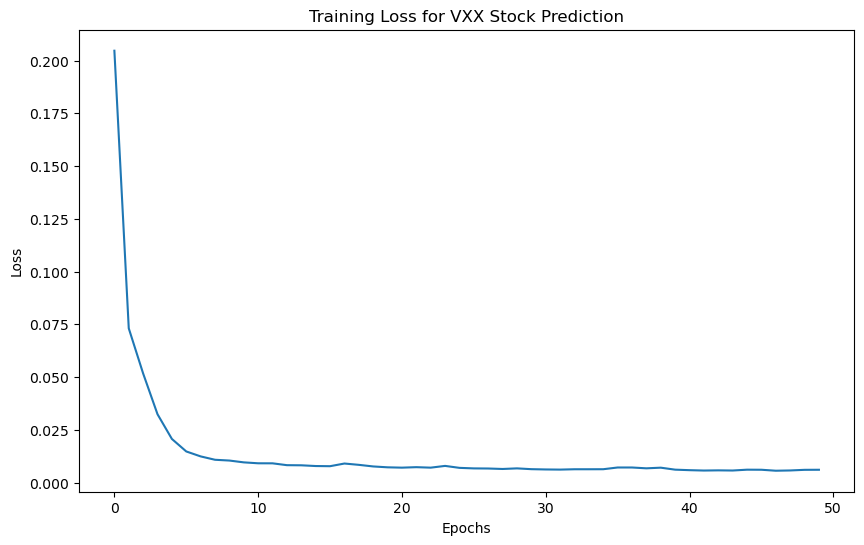

[*********************100%***********************]  1 of 1 completed

Predicting for VXX


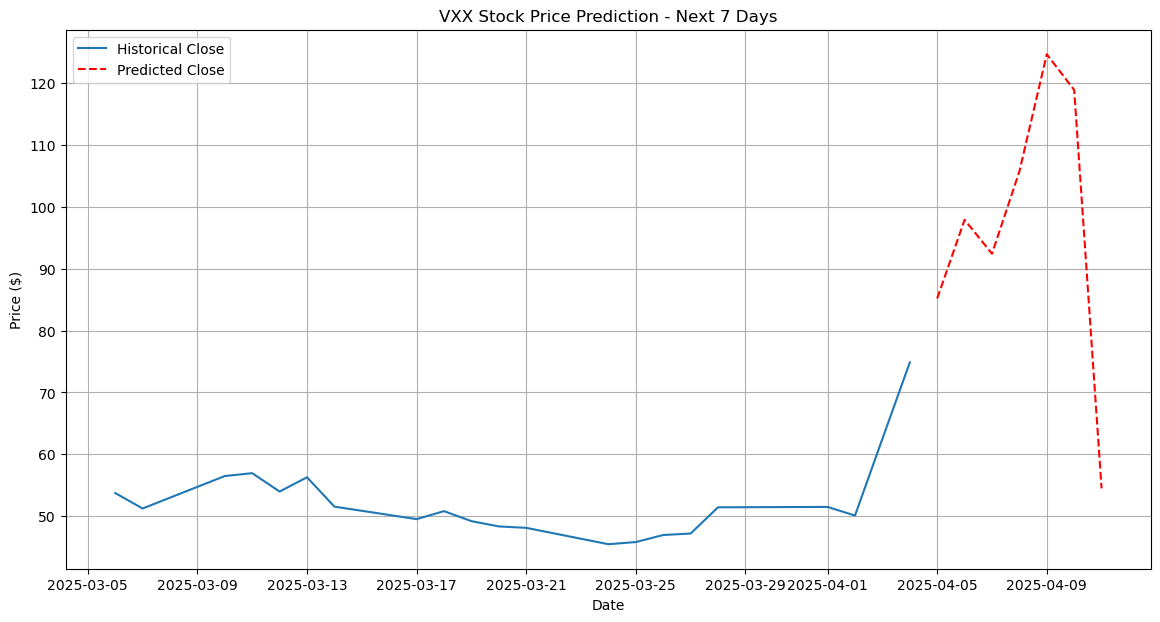


Predicted closing prices for the next 7 days:
2025-04-05: $85.20
2025-04-06: $97.93
2025-04-07: $92.44
2025-04-08: $105.74
2025-04-09: $124.71
2025-04-10: $118.92
2025-04-11: $54.48
Training model for ARKK


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1725
Epoch [2/50], Loss: 0.0752
Epoch [3/50], Loss: 0.0493
Epoch [4/50], Loss: 0.0312
Epoch [5/50], Loss: 0.0216
Epoch [6/50], Loss: 0.0165
Epoch [7/50], Loss: 0.0139
Epoch [8/50], Loss: 0.0126
Epoch [9/50], Loss: 0.0118
Epoch [10/50], Loss: 0.0112
Epoch [11/50], Loss: 0.0105
Epoch [12/50], Loss: 0.0107
Epoch [13/50], Loss: 0.0102
Epoch [14/50], Loss: 0.0097
Epoch [15/50], Loss: 0.0099
Epoch [16/50], Loss: 0.0095
Epoch [17/50], Loss: 0.0092
Epoch [18/50], Loss: 0.0092
Epoch [19/50], Loss: 0.0092
Epoch [20/50], Loss: 0.0090
Epoch [21/50], Loss: 0.0092
Epoch [22/50], Loss: 0.0084
Epoch [23/50], Loss: 0.0088
Epoch [24/50], Loss: 0.0089
Epoch [25/50], Loss: 0.0086
Epoch [26/50], Loss: 0.0086
Epoch [27/50], Loss: 0.0089
Epoch [28/50], Loss: 0.0087
Epoch [29/50], Loss: 0.0083
Epoch [30/50], Loss: 0.0083
Epoch [31/50], Loss: 0.0081
Epoch [32/50], Loss: 0.0086
Epoch [33/50], Loss: 0.0083
Epoch [34/50], Loss: 0.0078
Epoch [35/50], Loss: 0.0078
Epoch [36/50], Loss: 0.0078
E

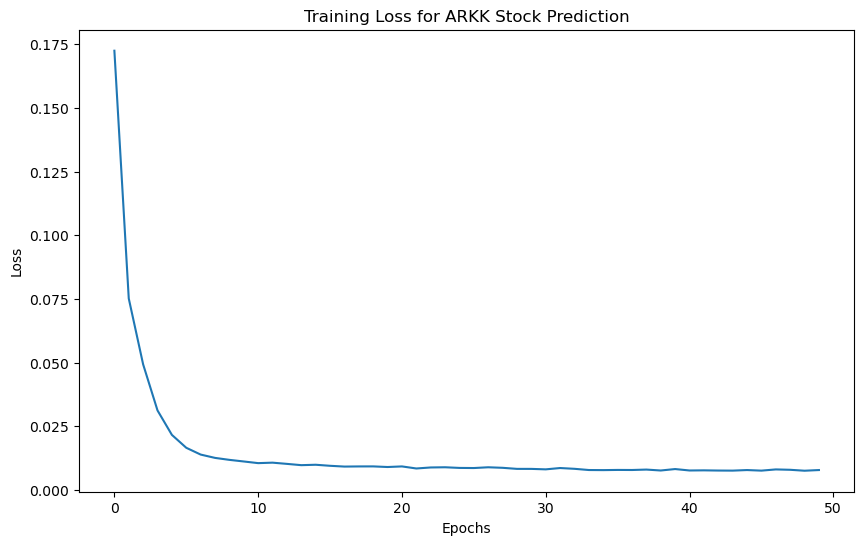

[*********************100%***********************]  1 of 1 completed

Predicting for ARKK


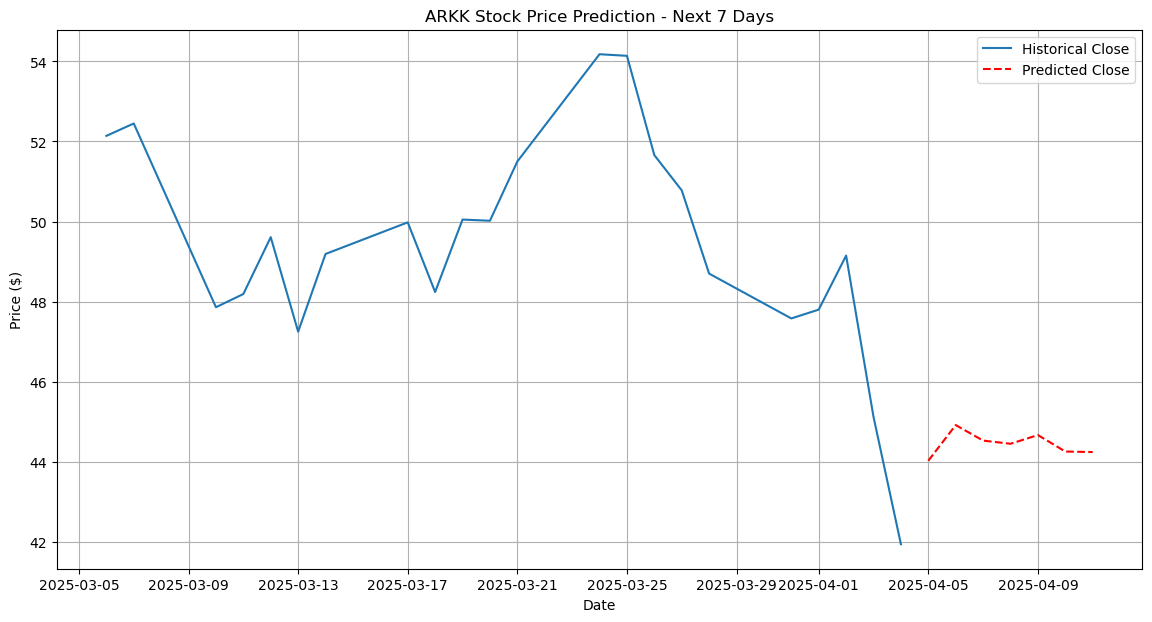


Predicted closing prices for the next 7 days:
2025-04-05: $44.03
2025-04-06: $44.92
2025-04-07: $44.53
2025-04-08: $44.45
2025-04-09: $44.67
2025-04-10: $44.26
2025-04-11: $44.24
Training model for NIO


[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.1962
Epoch [2/50], Loss: 0.0826
Epoch [3/50], Loss: 0.0612
Epoch [4/50], Loss: 0.0429
Epoch [5/50], Loss: 0.0296
Epoch [6/50], Loss: 0.0218
Epoch [7/50], Loss: 0.0183
Epoch [8/50], Loss: 0.0162
Epoch [9/50], Loss: 0.0148
Epoch [10/50], Loss: 0.0144
Epoch [11/50], Loss: 0.0143
Epoch [12/50], Loss: 0.0141
Epoch [13/50], Loss: 0.0135
Epoch [14/50], Loss: 0.0129
Epoch [15/50], Loss: 0.0129
Epoch [16/50], Loss: 0.0124
Epoch [17/50], Loss: 0.0124
Epoch [18/50], Loss: 0.0117
Epoch [19/50], Loss: 0.0119
Epoch [20/50], Loss: 0.0123
Epoch [21/50], Loss: 0.0120
Epoch [22/50], Loss: 0.0119
Epoch [23/50], Loss: 0.0121
Epoch [24/50], Loss: 0.0112
Epoch [25/50], Loss: 0.0114
Epoch [26/50], Loss: 0.0111
Epoch [27/50], Loss: 0.0117
Epoch [28/50], Loss: 0.0114
Epoch [29/50], Loss: 0.0115
Epoch [30/50], Loss: 0.0110
Epoch [31/50], Loss: 0.0109
Epoch [32/50], Loss: 0.0116
Epoch [33/50], Loss: 0.0108
Epoch [34/50], Loss: 0.0111
Epoch [35/50], Loss: 0.0111
Epoch [36/50], Loss: 0.0109
E

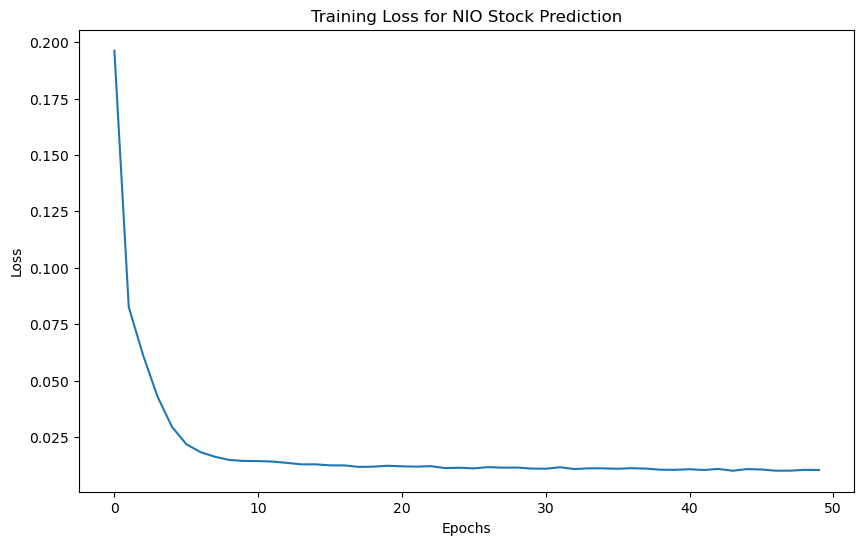

[*********************100%***********************]  1 of 1 completed

Predicting for NIO


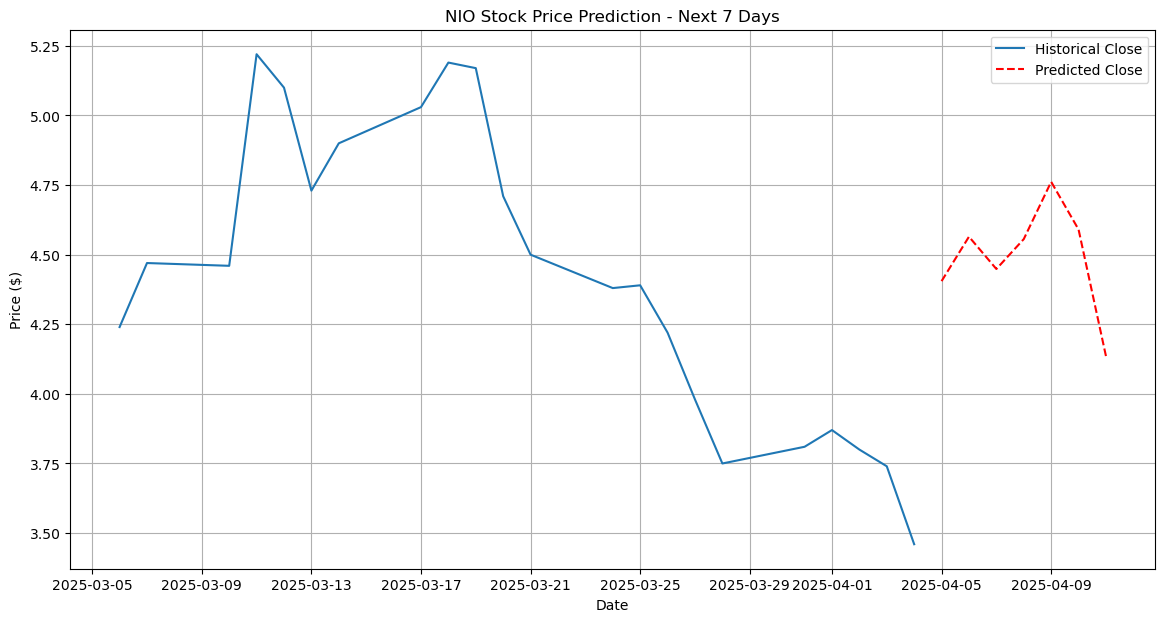


Predicted closing prices for the next 7 days:
2025-04-05: $4.40
2025-04-06: $4.56
2025-04-07: $4.45
2025-04-08: $4.56
2025-04-09: $4.76
2025-04-10: $4.59
2025-04-11: $4.14


In [16]:
tickers = [
  "RIVN",
  "NVDA",
  "NIO",
  "TSM",
  "WMT",
  "JNJ",
  "VZ",
  "PFE",
  "BA",
  "CAT",
  "MMM",
  "IBM",
  "MCD",
  "DIS",
  "PG",
  "TRMB",
  "ORCL",
  "CSCO",
  "CMCSA",
  "QS",
  "SLDP",
  "LCID",
  "UVXY",
  "VXX",
  "ARKK",
  "NIO"
] 
for ticker in tickers:
  print(f"Training model for {ticker}")
  model, features_scaled, window_size, ticker, scaler, stock_data = train(ticker)
  print(f"Predicting for {ticker}")
  predict(model, features_scaled, window_size, ticker, scaler, stock_data)